## Implementation of A Unified Evaluation Framework for Epistemic Predictions

In [95]:
#Import libraries
import tensorflow as tf
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
from tensorflow import keras
from itertools import chain, combinations
import matplotlib.patches as mpatches
from keras.utils import to_categorical 
from torch.distributions import Dirichlet
from scipy.spatial import distance

## LOADING DATA

In [96]:
# Loading CIFAR10 and data split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

k = 20  # number of non-singleton focal sets 
num_classes = 10
input_shape = (32, 32, 3)  #standard CIFAR10 data shape

In [97]:
# Scaling images to [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_test_org = x_test

# Standard normalizing
x_train = (x_train - np.array([[[0.4914, 0.4822, 0.4465]]])) / np.array([[[0.2023, 0.1994, 0.2010]]])
x_test = (x_test - np.array([[[0.4914, 0.4822, 0.4465]]])) / np.array([[[0.2023, 0.1994, 0.2010]]])

y_train = y_train[:,0]
y_test = y_test[:,0]

# Validation split
val_samples = -10000

x_val = x_train[val_samples:]
y_val = y_train[val_samples:]

x_train = x_train[:val_samples]
y_train = y_train[:val_samples]

y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)

In [98]:
# CIFAR10 classes
classes = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [99]:
# Dict of classes
num_clusters = len(classes)
classes_dict = {c:num for c,num in zip(classes, range(len(classes)))}
classes_dict_inverse = {num:c for c,num in zip(classes, range(len(classes)))}
classes_dict, classes_dict_inverse

({'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9},
 {0: 'airplane',
  1: 'automobile',
  2: 'bird',
  3: 'cat',
  4: 'deer',
  5: 'dog',
  6: 'frog',
  7: 'horse',
  8: 'ship',
  9: 'truck'})

In [100]:
# Load npy and pkl files
def load_npy(model_folder, filename):
    filepath = f"{model_folder}/{filename}"
    return np.load(filepath)

def load_pickle(model_folder, filename):
    filepath = f"{model_folder}/{filename}"
    with open(filepath, 'rb') as file:
        return pickle.load(file)

In [101]:
# Loading optimal subsets of classes
new_classes = load_pickle("CIFAR10", "new_classes.pkl")
new_classes

[{'airplane'},
 {'automobile'},
 {'bird'},
 {'cat'},
 {'deer'},
 {'dog'},
 {'frog'},
 {'horse'},
 {'ship'},
 {'truck'},
 {'automobile', 'deer'},
 {'bird', 'deer'},
 {'automobile', 'bird'},
 {'cat', 'frog'},
 {'automobile', 'ship'},
 {'deer', 'frog'},
 {'automobile', 'bird', 'deer'},
 {'cat', 'truck'},
 {'automobile', 'frog'},
 {'dog', 'horse'},
 {'bird', 'frog'},
 {'cat', 'deer'},
 {'bird', 'dog'},
 {'automobile', 'deer', 'frog'},
 {'horse', 'truck'},
 {'automobile', 'cat'},
 {'frog', 'ship'},
 {'cat', 'dog'},
 {'bird', 'deer', 'frog'},
 {'cat', 'horse'}]

In [102]:
# Adding the full set/universal set to new_classes
new_classes_with_full = new_classes + [set(classes)]
new_classes_with_full, len(new_classes_with_full)

([{'airplane'},
  {'automobile'},
  {'bird'},
  {'cat'},
  {'deer'},
  {'dog'},
  {'frog'},
  {'horse'},
  {'ship'},
  {'truck'},
  {'automobile', 'deer'},
  {'bird', 'deer'},
  {'automobile', 'bird'},
  {'cat', 'frog'},
  {'automobile', 'ship'},
  {'deer', 'frog'},
  {'automobile', 'bird', 'deer'},
  {'cat', 'truck'},
  {'automobile', 'frog'},
  {'dog', 'horse'},
  {'bird', 'frog'},
  {'cat', 'deer'},
  {'bird', 'dog'},
  {'automobile', 'deer', 'frog'},
  {'horse', 'truck'},
  {'automobile', 'cat'},
  {'frog', 'ship'},
  {'cat', 'dog'},
  {'bird', 'deer', 'frog'},
  {'cat', 'horse'},
  {'airplane',
   'automobile',
   'bird',
   'cat',
   'deer',
   'dog',
   'frog',
   'horse',
   'ship',
   'truck'}],
 31)

## LOADING PREDICTIONS

In [103]:
cnn_preds = load_npy("CIFAR10", "cnn_preds_cifar10.npy")
lbbnn_100_preds = load_npy("CIFAR10", "lbbnn_preds_cifar10_100.npy")
de_15_preds = load_npy("CIFAR10", "de_preds_cifar10_15.npy")
edl_alpha = load_npy("CIFAR10", "test_alpha_cifar10.npy")
creinn_preds = load_pickle("CIFAR10", "creinn_preds_cifar10")
ecnn_preds = load_npy("CIFAR10", "ecnn_preds_cifar10_mass.npy")
rsnn_preds = load_npy("CIFAR10", "rscnn_preds_cifar10.npy")
ddu_preds = load_npy("CIFAR10", "ddu_preds_cifar10.npy")

In [104]:
# Generating samples from Dirichlet parameters (alpha) of Evidential Deep Learning model
edl_alpha = edl_alpha / np.sum(edl_alpha, axis=1, keepdims=True)
m = Dirichlet(torch.tensor(edl_alpha))
m = m.sample((100,)).permute(1, 0, 2)  # 100 samples
edl_alpha_pred_100 = m.numpy()

In [105]:
print("Shape of SNN predictions:", cnn_preds.shape)
print("Shape of LB-BNN predictions (100 samples):", lbbnn_100_preds.shape)
print("Shape of Deep Ensembles predictions (15 models):", de_15_preds.shape)
print("Shape of Evidential model predictions (100 alpha samples):", edl_alpha_pred_100.shape)
print("Shape of CreINN predictions:", creinn_preds['lower probs'].shape)
print("Shape of E-CNN predictions:", ecnn_preds.shape)
print("Shape of RS-NN predictions:", rsnn_preds.shape)
print("Shape of DDU predictions:", ddu_preds.shape)

Shape of SNN predictions: (10000, 10)
Shape of LB-BNN predictions (100 samples): (10000, 100, 10)
Shape of Deep Ensembles predictions (15 models): (10000, 15, 10)
Shape of Evidential model predictions (100 alpha samples): (10000, 100, 10)
Shape of CreINN predictions: (10, 10000, 10)
Shape of E-CNN predictions: (10000, 1023)
Shape of RS-NN predictions: (10000, 30)
Shape of DDU predictions: (10000, 10)


In [106]:
# BMA and Ensemble Averaged predictions
lbbnn_cifar10_bmaveraged = load_npy("CIFAR10", "lbbnn_cifar10_bma_averaged_preds.npy")
de_cifar10_averaged = load_npy("CIFAR10", "de_cifar10_averaged_preds.npy")

print("Shape of LB-BNN Bayesian Model Averaged predictions:", lbbnn_cifar10_bmaveraged.shape)
print("Shape of DE Averaged predictions:", de_cifar10_averaged.shape)

Shape of LB-BNN Bayesian Model Averaged predictions: (10000, 10)
Shape of DE Averaged predictions: (10000, 10)


## COMPUTING MASS FUNCTIONS

In [107]:
# Function to compute the lower probabilities for new_classes
def compute_lower_probs(preds, prob_to_lower_probs_coeff):
    lower_probs = preds @ prob_to_lower_probs_coeff
    return lower_probs

prob_to_lower_probs_coeff = np.zeros((len(classes), len(new_classes)))
for i in range(len(classes)):
    for j in range(len(new_classes)):
        if classes[i] in new_classes[j]:
           prob_to_lower_probs_coeff[i,j] = 1.0

prob_to_lower_probs_coeff, prob_to_lower_probs_coeff.shape

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
         1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
         1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
         0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0.

In [108]:
# Computing the lower probabilities for new_classes
lbbnn_100_lower_probs = np.min(compute_lower_probs(lbbnn_100_preds, prob_to_lower_probs_coeff), axis=1)
de_15_lower_probs = np.min(compute_lower_probs(de_15_preds, prob_to_lower_probs_coeff), axis=1)
creinn_lower_probs = np.min(compute_lower_probs(creinn_preds['lower probs'], prob_to_lower_probs_coeff), axis=0)
edl_alpha_pred_100_lower_probs = np.min(compute_lower_probs(edl_alpha_pred_100, prob_to_lower_probs_coeff), axis=1)

In [109]:
# Mobius inverse function to compute masses
def belief_to_mass(y_pred, set_c):
    n_samples, n_classes = y_pred.shape
    n_sets = len(set_c)
    mass = np.zeros((n_samples, n_sets))

    for i in range(n_samples):
        for j in range(n_sets):
            A = set_c[j]
            mass_ij = 0
            for B in set_c:
                  if set(B).issubset(A):
                    b_idx = set_c.index(B)
                    if 0 <= b_idx < n_classes:
                        mass_ij += ((-1)**(len(A)-len(B))) * (y_pred[i, b_idx])
            mass[i][j] = mass_ij
    return mass

In [110]:
# Computing mass functions from lower probabilities for all models
mass_lbbnn_100 = belief_to_mass(lbbnn_100_lower_probs, new_classes)
mass_de_15 = belief_to_mass(de_15_lower_probs, new_classes)
mass_edl_100 = belief_to_mass(edl_alpha_pred_100_lower_probs, new_classes)
mass_creinn = belief_to_mass(creinn_lower_probs, new_classes)
mass_ecnn = ecnn_preds  # Since E-CNN model predicts masses directly
mass_rsnn = belief_to_mass(rsnn_preds, new_classes)

In [111]:
# Adding full set/universal subset to the masses
# We use this since we compute mass functions for most optimal subsets, we might not get a valid mass function through Mobius inverse 
def add_full_set_to_mass(mass):
    mass[mass<0] = 0
    sums_ = 1 - np.sum(mass, axis=-1)
    sums_[sums_<0] = 0
    mass = np.append(mass, sums_[:, None], axis=-1)
    mass = mass/np.sum(mass, axis=-1)[:, None]
    return mass

In [112]:
mass_lbbnn_100 = add_full_set_to_mass(mass_lbbnn_100)
mass_de_15 = add_full_set_to_mass(mass_de_15)
mass_edl_100 = add_full_set_to_mass(mass_edl_100)
mass_creinn = add_full_set_to_mass(mass_creinn)
mass_ecnn = ecnn_preds  # Since E-CNN model predicts masses directly
mass_rsnn = add_full_set_to_mass(mass_rsnn)

In [113]:
# Calculating predicted labels class_preds
# SNN
cnn_class_preds = np.argmax(cnn_preds, axis = -1)

# LB-BNN, DE
lbbnn_100_class_preds = np.argmax(np.mean(lbbnn_100_preds, axis = 1), axis = -1)
de_15_class_preds = np.argmax(np.mean(de_15_preds, axis = 1), axis = -1)

# LB-BNN, DE Averaged predictions
lbbnn_bma_class_preds = np.argmax(lbbnn_cifar10_bmaveraged, axis = -1)
de_averaged_class_preds = np.argmax(de_cifar10_averaged, axis = -1)

# CreINN
creinn_probs = np.mean(creinn_preds['upper probs'], axis = 0)
creinn_class_preds = np.argmax(creinn_probs, axis = -1)

# ESNN, RS-NN 
# Computing pignistic probability
def final_betp_coeff(new_classes, classes):
  betp_matrix = np.zeros((len(new_classes), len(classes)))
  for i,c in enumerate(classes): 
      for j,A in enumerate(new_classes):
          if set([c]).issubset(A):
              betp_matrix[j,i] = 1/len(A)
  
  return betp_matrix

# Power set of classes
class_set = list(range(num_classes))

def powerset(set):
    s = list(set)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

sets = list(powerset(classes))
sets.remove(sets[0])
sets = [set(subset) for subset in sets]

# ESNN
pignistic_ecnn = mass_ecnn @ final_betp_coeff(sets, classes)
ecnn_class_preds = np.argmax(pignistic_ecnn, axis = -1)

# RS-NN
pignistic_rsnn = mass_rsnn @ final_betp_coeff(new_classes_with_full, classes)
rsnn_class_preds = np.argmax(pignistic_rsnn, axis = -1)

# EDL
edl_alpha_pred_100_class_preds = np.argmax(np.mean(edl_alpha_pred_100, axis = 1), axis = -1)

# DDU
ddu_class_preds = np.argmax(ddu_preds, axis = -1)

In [114]:
# Calculate accuracy for all models
def calculate_accuracy(preds, true_labels):
    correct_predictions = np.sum(preds == true_labels)
    total_predictions = len(true_labels)
    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy

# Calculate and print accuracy for each model
print("SNN Accuracy:", calculate_accuracy(cnn_class_preds, y_test), "%")
print("LB-BNN Accuracy:", calculate_accuracy(lbbnn_100_class_preds, y_test), "%")
print("DE Accuracy:", calculate_accuracy(de_15_class_preds, y_test), "%")
print("EDL Accuracy:", calculate_accuracy(edl_alpha_pred_100_class_preds, y_test), "%")
print("CreINN Accuracy:", calculate_accuracy(creinn_class_preds, y_test), "%")
print("ESNN Accuracy:", calculate_accuracy(ecnn_class_preds, y_test), "%")
print("RS-NN Accuracy:", calculate_accuracy(rsnn_class_preds, y_test), "%")
print("DDU Accuracy:", calculate_accuracy(ddu_class_preds, y_test), "%")

SNN Accuracy: 90.25 %
LB-BNN Accuracy: 89.24 %
DE Accuracy: 93.77 %
EDL Accuracy: 59.089999999999996 %
CreINN Accuracy: 88.36 %
ESNN Accuracy: 83.5 %
RS-NN Accuracy: 92.99 %
DDU Accuracy: 91.34 %


In [115]:
# Calculate Expected Calibration Error (ECE) for all models
def expected_calibration_error(confidences, predictions, true_labels, num_bins=10):
    confidences = np.max(confidences, axis=1)
    bins = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(confidences, bins, right=True)
    bin_accuracy = np.zeros(num_bins)
    bin_confidence = np.zeros(num_bins)
    weights = np.zeros(num_bins)

    for i in range(1, num_bins + 1):
        bin_mask = (bin_indices == i)
        weights[i-1] = sum(bin_mask)
        if sum(bin_mask) != 0:
            bin_accuracy[i - 1] = np.mean(np.equal(predictions[bin_mask], true_labels[bin_mask]))
            bin_confidence[i - 1] = np.mean(confidences[bin_mask])
            
    ece = np.sum(np.abs(bin_accuracy - bin_confidence) * (weights/len(true_labels)))

    return ece

ece_cnn = expected_calibration_error(cnn_preds, cnn_class_preds, y_test)
ece_lbbnn_100 = expected_calibration_error(np.mean(lbbnn_100_preds, axis = 1), lbbnn_100_class_preds, y_test)
ece_de_15 = expected_calibration_error(np.mean(de_15_preds, axis = 1), de_15_class_preds, y_test)
ece_creinn = expected_calibration_error(creinn_probs, creinn_class_preds, y_test)
ece_ecnn = expected_calibration_error(pignistic_ecnn, ecnn_class_preds, y_test)
ece_rsnn = expected_calibration_error(pignistic_rsnn, rsnn_class_preds, y_test)
ece_edl = expected_calibration_error(np.mean(edl_alpha_pred_100, axis = 1), edl_alpha_pred_100_class_preds, y_test)
ece_ddu = expected_calibration_error(ddu_preds, ddu_class_preds, y_test)

print("SNN ECE:", ece_cnn)
print("LB-BNN ECE:", ece_lbbnn_100)
print("DE ECE:", ece_de_15)
print("EDL ECE:", ece_edl)
print("CreINN ECE:", ece_creinn)
print("ESNN ECE:", ece_ecnn)
print("RS-NN ECE:", ece_rsnn)
print("DDU ECE:", ece_ddu)

SNN ECE: 0.06685163495838639
LB-BNN ECE: 0.056522203591465925
DE ECE: 0.007494779595732692
EDL ECE: 0.047178181022405626
CreINN ECE: 0.010804710406064972
ESNN ECE: 0.6496909464096858
RS-NN ECE: 0.0509051653662029
DDU ECE: 0.04395226729810236


## CREDAL SET VERTICES

In [116]:
# Function to compute vertices of credal set
# Approximation function with permutations with true class in the first and last index
def compute_vertices(masses, classes, subsets):
    vertices = []    
    subset_permutations = []
   
    for i,c in enumerate(classes):
      p_0 = classes.copy()
      p_0[0], p_0[i] = p_0[i], p_0[0]
      
      p_1 = classes.copy()
      p_1[-1], p_1[i] = p_1[i], p_1[-1]
      
      subset_permutations = subset_permutations + [p_0] + [p_1]
    # subset_permutations =  list(itertools.permutations(classes))
    coeffs = []
    
    for perm in subset_permutations:
        coeffs.append(np.zeros((len(subsets), len(classes))))
        for i, curr_elem in enumerate(perm):
            perm_class_index = classes.index(perm[i])
            for m,c in enumerate(subsets):
              if curr_elem in c:
                for k in range(i):
                  if perm[k] in c:
                    break
                else:
                    coeffs[-1][m][perm_class_index] = 1
        
    coeffs = np.array(coeffs)[None,:,:,:]
    vertices = np.sum(masses[:,None,:,None] * coeffs, axis=-2)
    return vertices

In [117]:
# Computing the vertices of credal sets
lbbnn_vertices = compute_vertices(mass_lbbnn_100, classes, new_classes_with_full)
de_vertices = compute_vertices(mass_de_15, classes, new_classes_with_full)
edl_vertices = compute_vertices(mass_edl_100, classes, new_classes_with_full)
creinn_vertices = compute_vertices(mass_creinn, classes, new_classes_with_full)
ecnn_vertices = compute_vertices(mass_ecnn, classes, sets) # E-CNN uses all the sets in the powerset
rsnn_vertices = compute_vertices(mass_rsnn, classes, new_classes_with_full)

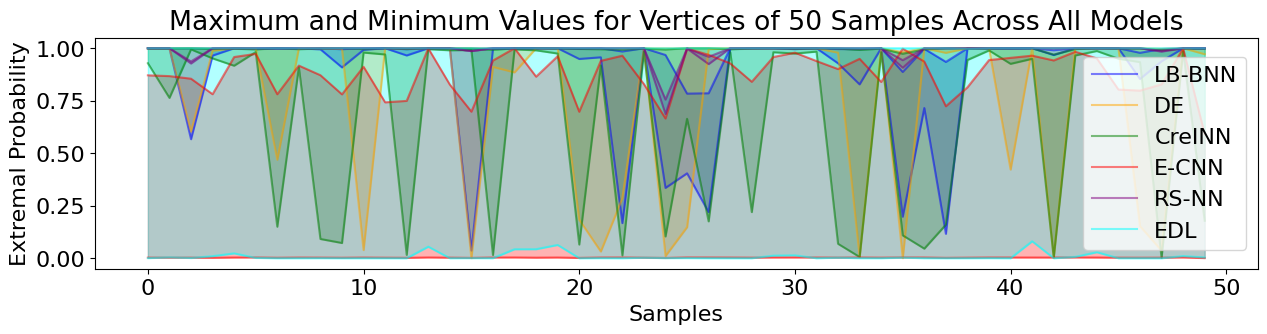

In [118]:
plt.rcParams.update({'font.size': 16})

models_vertices = {
    "LB-BNN": lbbnn_vertices,
    "DE": de_vertices,
    "CreINN": creinn_vertices,
    "E-CNN": ecnn_vertices,
    "RS-NN": rsnn_vertices,
    "EDL": edl_vertices
}

models = {
    "LB-BNN": lbbnn_100_class_preds,
    "DE": de_15_class_preds,
    "CreINN": creinn_class_preds,
    "E-CNN": ecnn_class_preds,
    "RS-NN": rsnn_class_preds,
    "EDL": edl_alpha_pred_100_class_preds,
    "DDU": ddu_class_preds
}

colors = ['blue', 'orange', 'green', 'red', 'purple', 'cyan']

# Plot maximum and minimum values for all models
plt.figure(figsize=(15, 3))
for i, (model_name, model_vertices) in enumerate(models_vertices.items()):
    # Adjust the number of samples
    model_vertices_100 = model_vertices[:50]
    
    max_values =  []
    min_values = []
    for j,v in enumerate(model_vertices_100):
        pred_class = models[model_name][j]
        max_values.append(v[pred_class*2, pred_class])
        min_values.append(v[(pred_class*2)+1, pred_class])
        
    plt.plot(max_values, color=colors[i], label=f'{model_name}', alpha=0.5)
    plt.plot(min_values, color=colors[i], alpha=0.5)
    
    plt.fill_between(range(len(max_values)), max_values, min_values, color=colors[i], alpha=0.3)
    

plt.xlabel('Samples')
plt.ylabel('Extremal Probability')
plt.title('Maximum and Minimum Values for Vertices of 50 Samples Across All Models')
plt.legend()
plt.show()

## KL DIVERGENCE

In [119]:
# Calculating KL divergence between ground truth and epistemic predictions
kl_divs_models = {}
near_vertex_kl_models = {}

# Define a function to compute KL divergence for a given model
def compute_kl_div(vertices_list):
    epsilon = 1e-10 
    vertices_list = np.clip(vertices_list, a_max=None, a_min=epsilon)
    if np.sum(vertices_list==0) != 0:
        print(np.sum(vertices_list==0))
    return np.min(np.sum(y_test_one_hot[:,None, :] * np.log((y_test_one_hot[:, None, :]+epsilon) / vertices_list), axis=-1), axis=-1)

# Compute KL divergence and nearest vertex for each model
for model_name, vertices_list in tqdm(models_vertices.items()):
    kl_divs_models[model_name] = compute_kl_div(vertices_list)

100%|██████████| 6/6 [00:00<00:00, 54.86it/s]


In [120]:
# Calculating Jensen-Shannon divergence between ground truth and epistemic predictions
js_divs_models = {}

# Define a function to compute JS divergence for a given model
def compute_js_div(vertices_list):
    epsilon = 1e-10
    vertices_list = np.clip(vertices_list, a_max=None, a_min=epsilon)
    v = distance.jensenshannon(y_test_one_hot[:, None, :], vertices_list, axis=-1)
    return np.min(v, axis =-1)

# Compute JS divergence for each model
for model_name, vertices_list in tqdm(models_vertices.items()):
    js_divs_models[model_name] = compute_js_div(vertices_list)

100%|██████████| 6/6 [00:00<00:00, 11.85it/s]


In [121]:
# Compute KL distance for point predictions
kl_divs_models_point_preds = {}
js_divs_models_point_preds = {}

model_names = ["SNN", "LB-BNN Avg", "DE Avg", "DDU"]
model_preds = [cnn_preds, lbbnn_cifar10_bmaveraged, de_cifar10_averaged, ddu_preds]

for model_name, model_p in zip(model_names, model_preds):
    kl_divs_models_point_preds[model_name] = compute_kl_div(model_p[:, None, :])
    
for model_name, model_p in zip(model_names, model_preds):
    js_divs_models_point_preds[model_name] = compute_js_div(model_p[:, None, :])

In [122]:
# Print KL Divergences for all models
for model_name in kl_divs_models:
    print(f"Model: {model_name}")
    print("KL Divergence:", np.mean(kl_divs_models[model_name]), np.std(kl_divs_models[model_name]))
    print("JS Divergence:", np.mean(js_divs_models[model_name]), np.std(js_divs_models[model_name]))

# Print JS Divergences for all models
for model_name in kl_divs_models_point_preds:
    print(f"Model: {model_name}")
    print("KL Divergence:", np.mean(kl_divs_models_point_preds[model_name]), np.std(kl_divs_models_point_preds[model_name]))
    print("JS Divergence:", np.mean(js_divs_models_point_preds[model_name]), np.std(js_divs_models_point_preds[model_name]))

Model: LB-BNN
KL Divergence: 0.24267902895131546 1.3150367373753233
JS Divergence: 0.07813563706377034 0.18273026095960707
Model: DE
KL Divergence: 0.03058258186459899 0.3674716371251696
JS Divergence: 0.014124757491299931 0.07583260867191491
Model: CreINN
KL Divergence: 0.05783756034053599 0.3737329332480058
JS Divergence: 0.04969054165581614 0.10457508640384688
Model: E-CNN
KL Divergence: 0.1931838118358487 0.21494382528869704
JS Divergence: 0.21218357878498245 0.13308154910064413
Model: RS-NN
KL Divergence: 0.39830445458263775 1.8949592419982546
JS Divergence: 0.06437014360150413 0.1958823051742956
Model: EDL
KL Divergence: 0.002096250863082409 0.010412301119748864
JS Divergence: 0.010809028934585838 0.024579721115534088
Model: SNN
KL Divergence: 0.4806100505674909 1.7964992259508288
JS Divergence: 0.09799881575964026 0.22888715126090123
Model: LB-BNN Avg
KL Divergence: 0.4195402187318038 1.5194741048573952
JS Divergence: 0.11863696718104659 0.2304138359529272
Model: DE Avg
KL Diver

In [123]:
# Correctly Classified (CC) and Incorrectly Classified (ICC) samples
models = {
    "LB-BNN": lbbnn_100_class_preds,
    "DE": de_15_class_preds,
    "EDL": edl_alpha_pred_100_class_preds,
    "CreINN": creinn_class_preds,
    "E-CNN": ecnn_class_preds,
    "RS-NN": rsnn_class_preds
}

point_preds = {
    "SNN": cnn_class_preds,
    "LB-BNN Avg": lbbnn_bma_class_preds,
    "DE Avg": de_averaged_class_preds,
    "DDU": ddu_class_preds
}

incorrect_indices = {}
correct_indices = {}
incorrect_indices_avg = {}
correct_indices_avg = {}

for model_name, model_preds in models.items():
    incorrect_idx = np.nonzero(model_preds != y_test)[0]
    incorrect_indices[model_name] = incorrect_idx
    
    correct_idx = np.nonzero(model_preds == y_test)[0]
    correct_indices[model_name] = correct_idx

for model_name_point, model_preds_point in point_preds.items():
    incorrect_idx_avg = np.nonzero(model_preds_point != y_test)[0]
    incorrect_indices_avg[model_name_point] = incorrect_idx_avg
    
    correct_idx_avg = np.nonzero(model_preds_point == y_test)[0]
    correct_indices_avg[model_name_point] = correct_idx_avg

print("Incorrectly Classified (ICC)")
for model_name, incorrect_idx in incorrect_indices.items():
    print(f"Number of incorrectly classified samples for {model_name}: {len(incorrect_idx)}")
for model_name_point, incorrect_idx_point in incorrect_indices_avg.items():
    print(f"Number of incorrectly classified samples for {model_name_point}: {len(incorrect_idx_point)}")

print("Correctly Classified (CC)")
for model_name, correct_idx in correct_indices.items():
    print(f"Number of correctly classified samples for {model_name}: {len(correct_idx)}")
for model_name_point, correct_idx_point in correct_indices_avg.items():
    print(f"Number of correctly classified samples for {model_name_point}: {len(correct_idx_point)}")

Incorrectly Classified (ICC)
Number of incorrectly classified samples for LB-BNN: 1076
Number of incorrectly classified samples for DE: 623
Number of incorrectly classified samples for EDL: 4091
Number of incorrectly classified samples for CreINN: 1164
Number of incorrectly classified samples for E-CNN: 1650
Number of incorrectly classified samples for RS-NN: 701
Number of incorrectly classified samples for SNN: 975
Number of incorrectly classified samples for LB-BNN Avg: 1073
Number of incorrectly classified samples for DE Avg: 623
Number of incorrectly classified samples for DDU: 866
Correctly Classified (CC)
Number of correctly classified samples for LB-BNN: 8924
Number of correctly classified samples for DE: 9377
Number of correctly classified samples for EDL: 5909
Number of correctly classified samples for CreINN: 8836
Number of correctly classified samples for E-CNN: 8350
Number of correctly classified samples for RS-NN: 9299
Number of correctly classified samples for SNN: 9025
N

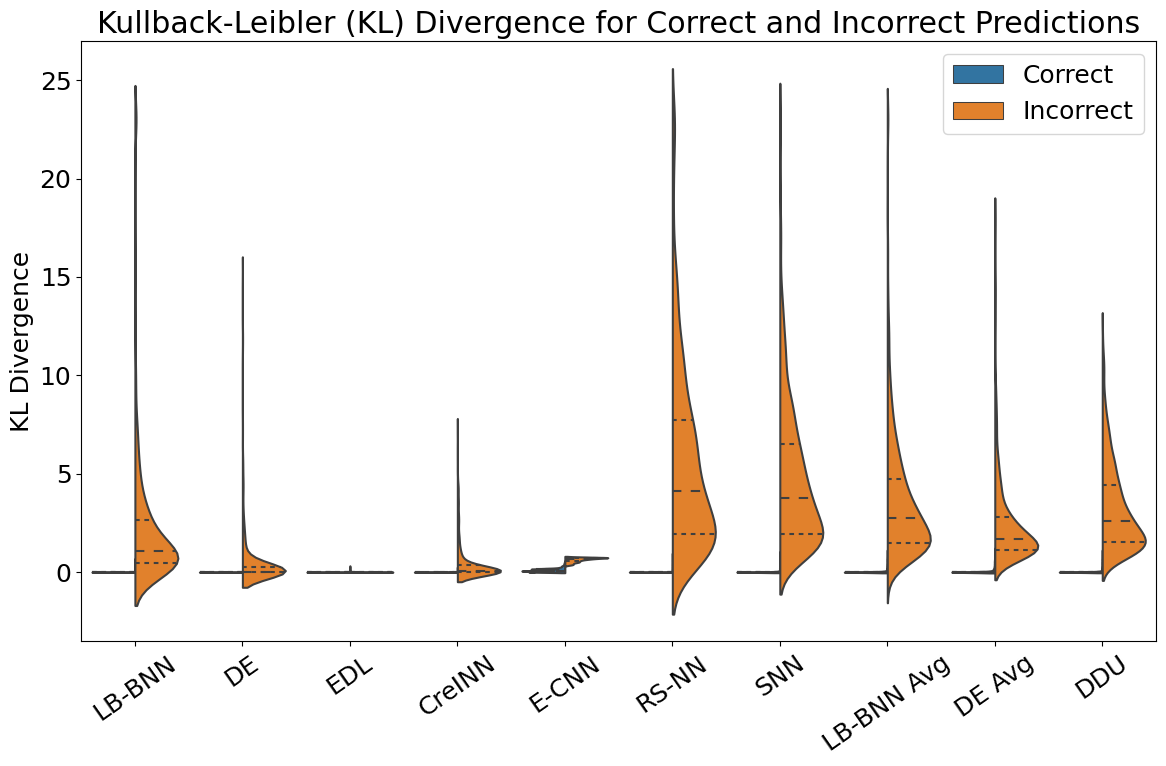

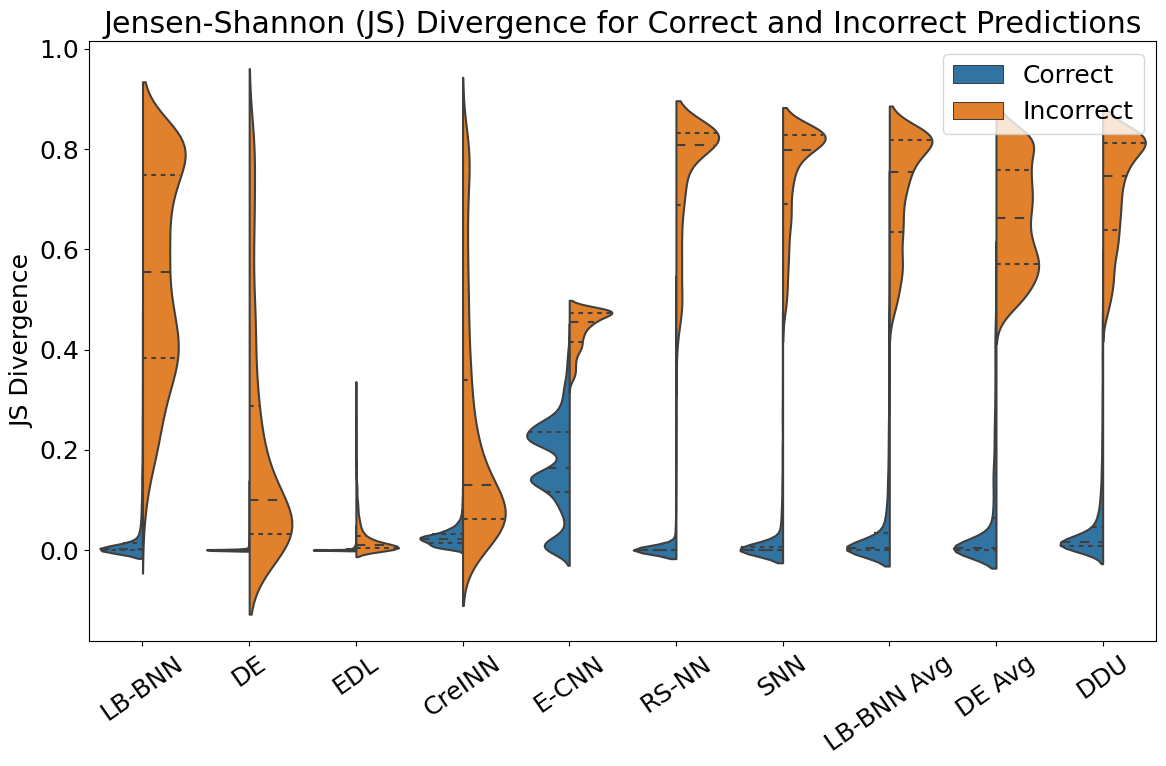

In [124]:
models = {
    "LB-BNN": lbbnn_100_class_preds,
    "DE": de_15_class_preds,
    "EDL": edl_alpha_pred_100_class_preds,
    "CreINN": creinn_class_preds,
    "E-CNN": ecnn_class_preds,
    "RS-NN": rsnn_class_preds,
}

point_preds = {
    "SNN": cnn_class_preds,
    "LB-BNN Avg": lbbnn_bma_class_preds,
    "DE Avg": de_averaged_class_preds,
    "DDU": ddu_class_preds
}

plt.rcParams.update({'font.size': 18})

def collect_divergences(models_dict, divs_models, divs_models_point_preds, indices, indices_avg):
    divs = []
    model_names = []
    
    for model_name in models_dict:
        divs.extend(divs_models[model_name][indices[model_name]])
        model_names.extend([model_name] * len(divs_models[model_name][indices[model_name]]))

    for model_name in point_preds:
        divs.extend(divs_models_point_preds[model_name][indices_avg[model_name]])
        model_names.extend([model_name] * len(divs_models_point_preds[model_name][indices_avg[model_name]]))
    
    return divs, model_names

def prepare_divergence_data(models, point_preds, kl_divs_models, js_divs_models, kl_divs_models_point_preds, js_divs_models_point_preds, 
                            correct_indices, incorrect_indices, correct_indices_avg, incorrect_indices_avg):
    # Collect KL divergences
    correct_kl_divs, model_names_correct = collect_divergences(models, kl_divs_models, kl_divs_models_point_preds, correct_indices, correct_indices_avg)
    incorrect_kl_divs, model_names_incorrect = collect_divergences(models, kl_divs_models, kl_divs_models_point_preds, incorrect_indices, incorrect_indices_avg)

    # Create DataFrames for KL Divergence
    df_kl = pd.DataFrame({
        'Model': model_names_correct + model_names_incorrect,
        'KL Divergence': correct_kl_divs + incorrect_kl_divs,
        'Type': ['Correct'] * len(correct_kl_divs) + ['Incorrect'] * len(incorrect_kl_divs)
    }).dropna()

    # Collect JS divergences
    correct_js_divs, model_names_js_correct = collect_divergences(models, js_divs_models, js_divs_models_point_preds, correct_indices, correct_indices_avg)
    incorrect_js_divs, model_names_js_incorrect = collect_divergences(models, js_divs_models, js_divs_models_point_preds, incorrect_indices, incorrect_indices_avg)

    # Create DataFrames for JS Divergence
    df_js = pd.DataFrame({
        'Model': model_names_js_correct + model_names_js_incorrect,
        'JS Divergence': correct_js_divs + incorrect_js_divs,
        'Type': ['Correct'] * len(correct_js_divs) + ['Incorrect'] * len(incorrect_js_divs)
    }).dropna()

    return df_kl, df_js

def plot_violin(ax, df, metric_name):
    df_correct = df[df['Type'] == 'Correct'].copy()
    df_correct['Hue'] = ['Correct'] * len(df_correct)
    sns.violinplot(x='Model', y=metric_name, hue='Type', data=df.set_index("Model").loc[["LB-BNN", "DE", "EDL", "CreINN", "E-CNN", "RS-NN", "SNN", "LB-BNN Avg", "DE Avg", "DDU"]].reset_index(drop=False), split=True, dropna=True, gap=.1, inner="quart", hue_order=['Correct', False], density_norm="width", ax=ax)
    df_incorrect = df[df['Type'] == 'Incorrect'].copy()
    df_incorrect['Hue'] = ['Incorrect'] * len(df_incorrect)
    sns.violinplot(x='Model', y=metric_name, hue='Type', data=df.set_index("Model").loc[["LB-BNN", "DE", "EDL", "CreINN", "E-CNN", "RS-NN", "SNN", "LB-BNN Avg", "DE Avg", "DDU"]].reset_index(drop=False), split=True, dropna=True, gap=.1, inner="quart", hue_order=[False, 'Incorrect'], density_norm="width", ax=ax)


def plot_divergence_metrics(models, point_preds, kl_divs_models, js_divs_models, kl_divs_models_point_preds, js_divs_models_point_preds, 
                            correct_indices, incorrect_indices, correct_indices_avg, incorrect_indices_avg):
    df_kl, df_js = prepare_divergence_data(models, point_preds, kl_divs_models, js_divs_models, kl_divs_models_point_preds, js_divs_models_point_preds, 
                                            correct_indices, incorrect_indices, correct_indices_avg, incorrect_indices_avg)
    
    # Create and plot KL Divergence
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_violin(ax, df_kl, 'KL Divergence')
    plt.title('Kullback-Leibler (KL) Divergence for Correct and Incorrect Predictions')
    ax.set_xlabel('')
    plt.ylabel('KL Divergence')
    ax.legend(ax.legend_.__dict__["legend_handles"][:2] ,['Correct', 'Incorrect'])
    plt.xticks(rotation=0)
    # Set axis labels and other details
    plt.xticks(rotation=35)
    plt.tight_layout()
    plt.show()

    # Create and plot JS Divergence
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_violin(ax, df_js, 'JS Divergence')
    plt.title('Jensen-Shannon (JS) Divergence for Correct and Incorrect Predictions')
    ax.set_xlabel('')
    plt.ylabel('JS Divergence')
    ax.legend(ax.legend_.__dict__["legend_handles"][:2] ,['Correct', 'Incorrect'])
    plt.xticks(rotation=0)
    # Set axis labels and other details
    plt.xticks(rotation=35)
    plt.tight_layout()
    plt.show()
    
    return df_kl, df_js

# Plot KL and JS for all models
df_kl, df_js = plot_divergence_metrics(models, point_preds, kl_divs_models, js_divs_models, kl_divs_models_point_preds, js_divs_models_point_preds, 
                        correct_indices, incorrect_indices, correct_indices_avg, incorrect_indices_avg)

In [125]:
# KL divergence dataframe with mean and std for correct and incorrect predictions
df_kl.groupby(["Model", "Type"]).describe()

KL Divergence                                    \
                             count      mean       std           min   
Model      Type                                                        
CreINN     Correct          8836.0  0.002754  0.005599  2.472460e-07   
           Incorrect        1164.0  0.475979  1.001358  1.217604e-05   
DDU        Correct          9134.0  0.030900  0.103666  2.026660e-06   
           Incorrect         866.0  3.243046  2.195917  7.141549e-01   
DE         Correct          9377.0  0.000134  0.001410  1.000000e-10   
           Incorrect         623.0  0.488870  1.395212  7.387257e-07   
DE Avg     Correct          9377.0  0.050052  0.134765  1.000000e-10   
           Incorrect         623.0  2.377964  1.999841  7.163492e-01   
E-CNN      Correct          8350.0  0.107838  0.092718 -9.582622e-08   
           Incorrect        1650.0  0.625083  0.114528  3.333527e-01   
EDL        Correct          5909.0  0.000057  0.000265  1.000000e-10   
           Incorrect        4091.0  0.005042  0.015820  1.658143e-10   
LB-BNN     Correct          8924.0  0.008948  0.037535  1.000000e-10   
           Incorrect        1076.0  2.181166  3.443877  9.072411e-03   
LB-BNN Avg Correct          8927.0  0.033931  0.113757  1.000000e-10   
           Incorrect        1073.0  3.627680  3.144769  1.000000e-10   
RS-NN      Correct          9299.0  0.009006  0.055187  1.000000e-10   
           Incorrect         701.0  5.562474  4.747386  4.239404e-01   
SNN        Correct          9025.0  0.021031  0.090244  1.000000e-10   
           Incorrect         975.0  4.734663  3.603823  7.007520e-01   

                                                                           
                               25%           50%           75%        max  
Model      Type                                                            
CreINN     Correct    5.428908e-04  1.554546e-03  3.127721e-03   0.257811  
           Incorrect  1.101220e-02  4.977587e-02  3.491248e-01   7.319649  
DDU        Correct    2.290870e-04  7.656764e-04  5.897219e-03   1.096949  
           Incorrect  1.528756e+00  2.595132e+00  4.446878e+00  12.051354  
DE         Correct    1.036238e-10  1.921480e-09  4.562407e-07   0.054796  
           Incorrect  3.125291e-03  2.854693e-02  2.483193e-01  15.252579  
DE Avg     Correct    1.193093e-07  3.445218e-05  1.193368e-02   1.182208  
           Incorrect  1.130155e+00  1.705590e+00  2.801174e+00  17.916590  
E-CNN      Correct    3.864155e-02  7.865951e-02  1.633768e-01   0.560551  
           Incorrect  5.406539e-01  6.604389e-01  7.255702e-01   0.749844  
EDL        Correct    1.000000e-10  1.000287e-10  9.173120e-06   0.006719  
           Incorrect  3.523423e-05  3.122706e-04  2.250601e-03   0.316354  
LB-BNN     Correct    2.869692e-08  5.503911e-06  5.423412e-04   0.687762  
           Incorrect  4.515442e-01  1.051121e+00  2.629109e+00  23.025851  
LB-BNN Avg Correct    2.385186e-07  4.041287e-05  3.339018e-03   1.098324  
           Incorrect  1.486923e+00  2.730762e+00  4.753879e+00  23.025851  
RS-NN      Correct    1.000002e-10  1.115990e-10  3.438235e-07   0.948432  
           Incorrect  1.925308e+00  4.136015e+00  7.713922e+00  23.025851  
SNN        Correct    1.000000e-10  1.000000e-10  1.462806e-04   1.026414  
           Incorrect  1.949237e+00  3.777400e+00  6.532039e+00  23.025851

## NON-SPECIFICITY

In [126]:
# Compute non-specificity
masses = {
    "LB-BNN": mass_lbbnn_100,
    "DE": mass_de_15,
    "EDL": mass_edl_100,
    "CreINN": mass_creinn,
    "RS-NN": mass_rsnn
}

def non_specific(models_preds_mass, new_classes):
    non_specif_all_models = {}
    for model_name, test_preds_mass in models_preds_mass.items():
        non_specif = []
        for i in range(len(test_preds_mass)):
            non_spec = 0
            for j, A in enumerate(new_classes):
                non_spec += test_preds_mass[i][j] * np.log(len(A))
            non_specif.append(non_spec)
        non_specif_all_models[model_name] = np.array(non_specif)
    return non_specif_all_models

non_specificity = non_specific(masses, new_classes_with_full)
non_specificity.update(non_specific({"E-CNN": mass_ecnn}, sets)) 

In [127]:
# The non-specificity for point predictions is zero
non_specificity_point_preds = {
    "SNN": np.zeros_like(y_test),
    "LB-BNN Avg": np.zeros_like(y_test),
    "DE Avg": np.zeros_like(y_test),
    "DDU": np.zeros_like(y_test)
}

In [128]:
# Mean non-specificity
for model_name, non_spec_values in non_specificity.items():
    print(f"Model: {model_name}")
    print("Non-Specificity:", np.mean(non_spec_values), np.std(non_spec_values))

for model_name, non_spec_values in non_specificity_point_preds.items():
    print(f"Model: {model_name}")
    print("Non-Specificity:", np.mean(non_spec_values), np.std(non_spec_values))

Model: LB-BNN
Non-Specificity: 0.16621622773704609 0.3980272283543192
Model: DE
Non-Specificity: 0.38465305428790814 0.7146169963131889
Model: EDL
Non-Specificity: 2.266749578698495 0.06887375793729195
Model: CreINN
Non-Specificity: 0.5960899559602606 0.811655272257293
Model: RS-NN
Non-Specificity: 0.008944351956413507 0.05222391541467891
Model: E-CNN
Non-Specificity: 1.6089262665392563 0.003082025958902224
Model: SNN
Non-Specificity: 0.0 0.0
Model: LB-BNN Avg
Non-Specificity: 0.0 0.0
Model: DE Avg
Non-Specificity: 0.0 0.0
Model: DDU
Non-Specificity: 0.0 0.0


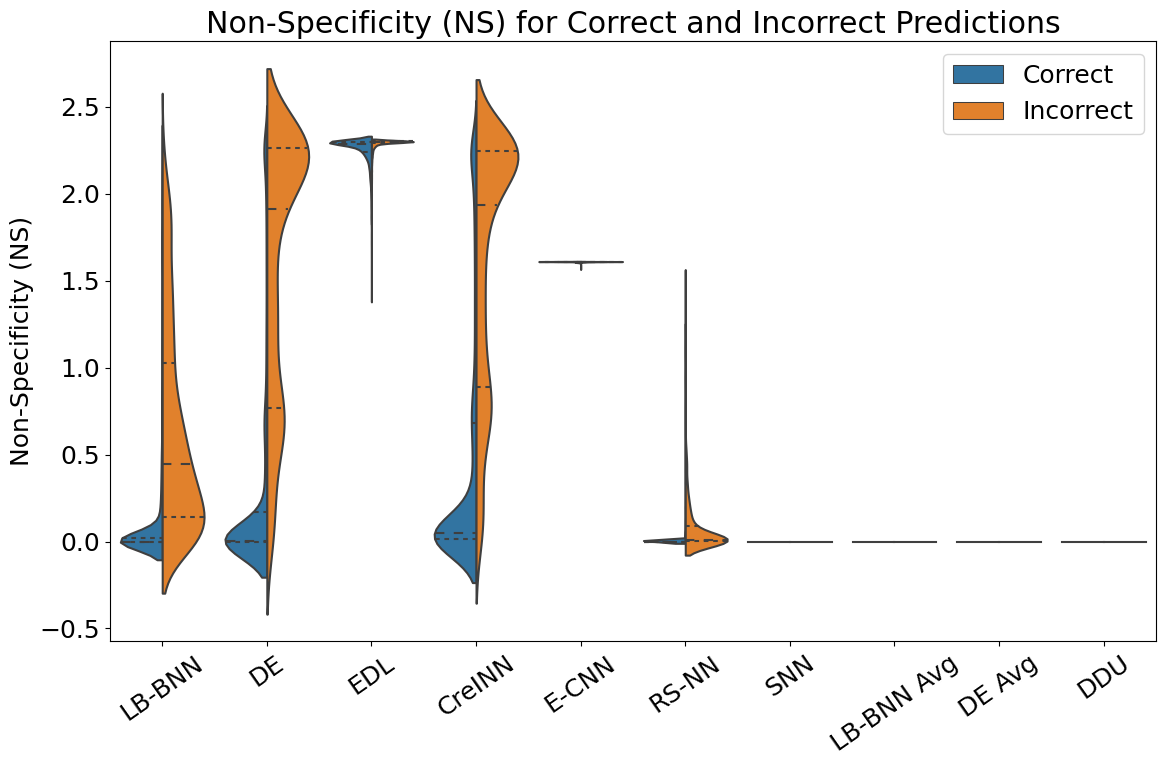

In [129]:
# Function to prepare Non-Specificity DataFrame
def prepare_non_specificity_df(non_specificity):
    non_spec_values = []
    model_names = []
    
    for model_name, values in non_specificity.items():
        non_spec_values.extend(values)
        model_names.extend([model_name] * len(values))

    correct_ns, model_names_correct = collect_divergences(models, non_specificity, non_specificity_point_preds, correct_indices, correct_indices_avg)
    incorrect_ns, model_names_incorrect = collect_divergences(models, non_specificity, non_specificity_point_preds, incorrect_indices, incorrect_indices_avg)

    # Create DataFrames for KL Divergence
    df_spec = pd.DataFrame({
        'Model': model_names_correct + model_names_incorrect,
        'Non-Specificity': correct_ns + incorrect_ns,
        'Type': ['Correct'] * len(correct_ns) + ['Incorrect'] * len(incorrect_ns)
    }).dropna()
    
    return df_spec

plt.rcParams.update({'font.size': 18})

def plot_non_specificity_metrics(models, non_specificity):
    # Prepare the DataFrame for non-specificity
    df_non_spec = prepare_non_specificity_df(non_specificity)

    # Create and plot Non-Specificity for Correct Predictions
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_violin(ax, df_non_spec, 'Non-Specificity')
    plt.title('Non-Specificity (NS) for Correct and Incorrect Predictions')
    ax.set_xlabel('')
    plt.ylabel('Non-Specificity (NS)')
    ax.legend(ax.legend_.__dict__["legend_handles"][:2] ,['Correct', 'Incorrect'])
    plt.xticks(rotation=35)
    plt.tight_layout()
    plt.show()
    
    return df_non_spec

# Call the function to plot non-specificity metrics
df_spec = plot_non_specificity_metrics(models, non_specificity)

## ESNN has similar non-spec for both correct and incorrect preds. very low variance in its non-spec, because the model always behaves imprecisely, while not giving much information.

In [130]:
# Non-Specificity dataframe with mean and std for correct and incorrect predictions
df_spec.groupby(["Model", "Type"]).describe()

Non-Specificity                                    \
                               count      mean       std           min   
Model      Type                                                          
CreINN     Correct            8836.0  0.465203  0.726710  1.067986e-04   
           Incorrect          1164.0  1.589664  0.731049  1.789804e-03   
DDU        Correct            9134.0  0.000000  0.000000  0.000000e+00   
           Incorrect           866.0  0.000000  0.000000  0.000000e+00   
DE         Correct            9377.0  0.306148  0.638583  0.000000e+00   
           Incorrect           623.0  1.566262  0.756250  1.688661e-07   
DE Avg     Correct            9377.0  0.000000  0.000000  0.000000e+00   
           Incorrect           623.0  0.000000  0.000000  0.000000e+00   
E-CNN      Correct            8350.0  1.608798  0.003325  1.565917e+00   
           Incorrect          1650.0  1.609577  0.001059  1.604894e+00   
EDL        Correct            5909.0  2.251860  0.082139  1.407509e+00   
           Incorrect          4091.0  2.288256  0.032701  1.837212e+00   
LB-BNN     Correct            8924.0  0.109475  0.322953  0.000000e+00   
           Incorrect          1076.0  0.636808  0.599674  0.000000e+00   
LB-BNN Avg Correct            8927.0  0.000000  0.000000  0.000000e+00   
           Incorrect          1073.0  0.000000  0.000000  0.000000e+00   
RS-NN      Correct            9299.0  0.003895  0.031495  1.076430e-34   
           Incorrect           701.0  0.075921  0.144760  2.199856e-15   
SNN        Correct            9025.0  0.000000  0.000000  0.000000e+00   
           Incorrect           975.0  0.000000  0.000000  0.000000e+00   

                                                                          
                               25%           50%           75%       max  
Model      Type                                                           
CreINN     Correct    1.444187e-02  4.915129e-02  6.832308e-01  2.301312  
           Incorrect  8.909848e-01  1.937725e+00  2.245924e+00  2.300835  
DDU        Correct    0.000000e+00  0.000000e+00  0.000000e+00  0.000000  
           Incorrect  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  
DE         Correct    1.646821e-06  4.204096e-04  1.672764e-01  2.302520  
           Incorrect  7.663845e-01  1.910757e+00  2.263149e+00  2.302512  
DE Avg     Correct    0.000000e+00  0.000000e+00  0.000000e+00  0.000000  
           Incorrect  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  
E-CNN      Correct    1.608244e+00  1.610217e+00  1.610516e+00  1.610573  
           Incorrect  1.609082e+00  1.609914e+00  1.610453e+00  1.610573  
EDL        Correct    2.239191e+00  2.286265e+00  2.300537e+00  2.302585  
           Incorrect  2.290967e+00  2.300674e+00  2.302248e+00  2.302585  
LB-BNN     Correct    2.416170e-06  2.731151e-04  2.198633e-02  2.291173  
           Incorrect  1.433312e-01  4.465245e-01  1.027032e+00  2.281790  
LB-BNN Avg Correct    0.000000e+00  0.000000e+00  0.000000e+00  0.000000  
           Incorrect  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  
RS-NN      Correct    2.473764e-16  6.854941e-12  9.972512e-07  1.554112  
           Incorrect  3.705782e-04  1.053844e-02  8.680196e-02  1.175953  
SNN        Correct    0.000000e+00  0.000000e+00  0.000000e+00  0.000000  
           Incorrect  0.000000e+00  0.000000e+00  0.000000e+00  0.000000

<Figure size 1200x800 with 0 Axes>

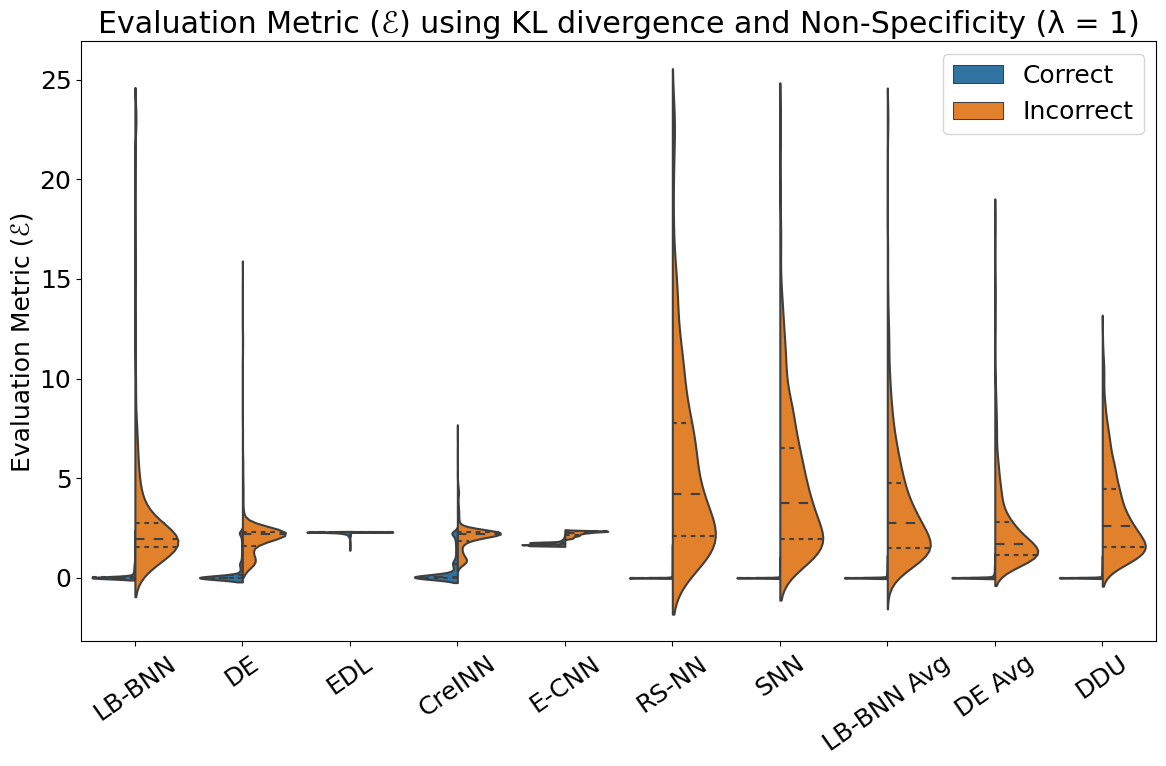

<Figure size 1200x800 with 0 Axes>

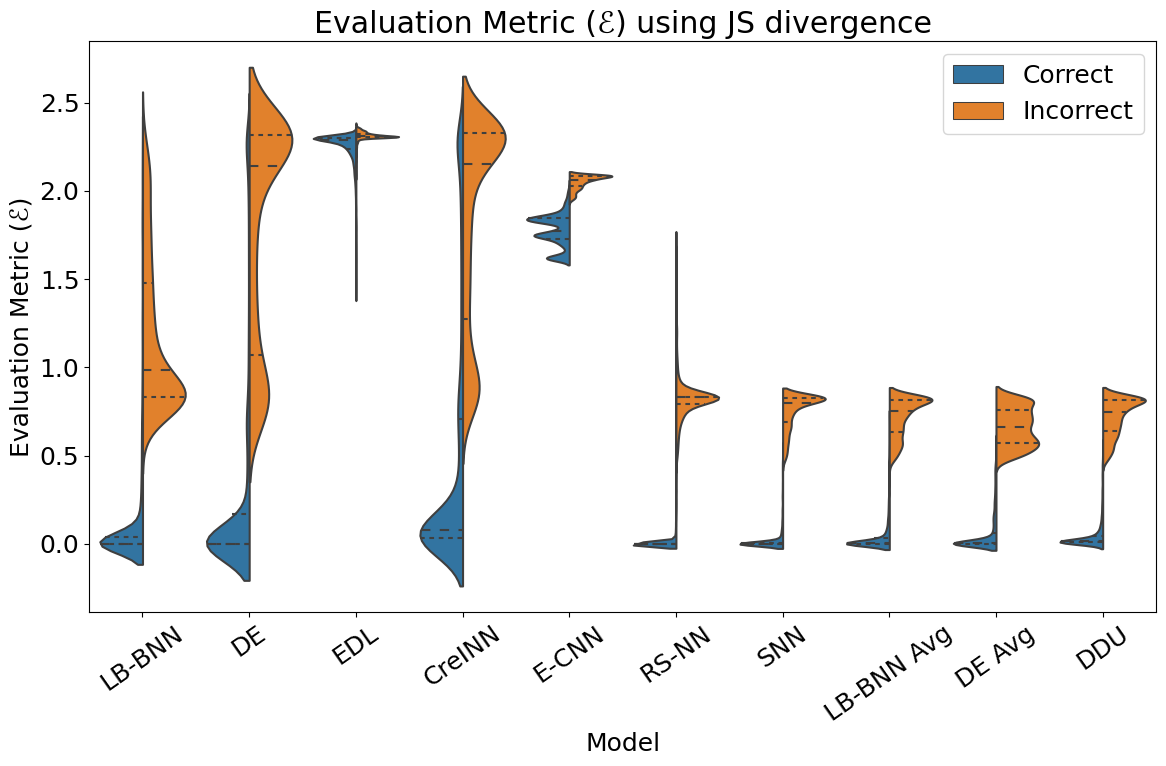

In [131]:
# Plot KL+NS
df_kl["combined"] = df_kl["KL Divergence"] + df_spec["Non-Specificity"] #\lambda = 1
df_js["e"] = df_js["JS Divergence"] + df_spec["Non-Specificity"] #\lambda = 1

# Plot the violin plot
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(12, 8))
plot_violin(ax, df_kl, 'combined')
plt.title('Evaluation Metric (\u2130) using KL divergence and Non-Specificity (\u03BB = 1)')
ax.set_xlabel('')
ax.legend(ax.legend_.__dict__["legend_handles"][:2] ,['Correct', 'Incorrect'])
plt.ylabel('Evaluation Metric (\u2130)')
plt.xticks(rotation=35)
plt.tight_layout()
plt.show()

# Plot the violin plot
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(12, 8))
plot_violin(ax, df_js, 'e')
plt.title('Evaluation Metric (\u2130) using JS divergence')
ax.legend(ax.legend_.__dict__["legend_handles"][:2] ,['Correct', 'Incorrect'])
plt.ylabel('Evaluation Metric (\u2130)')
plt.xticks(rotation=35)
plt.tight_layout()
plt.show()

## EVALUATION METRIC

In [132]:
def calculate_eval_metric(kl_divs_models, non_specific_models, lamda_values):
    eval_metrics = {}
    for model_name, kl_divs in kl_divs_models.items():
        eval_metrics[model_name] = {}
        for lamda in lamda_values:
            eval_metric = kl_divs + lamda * non_specific_models[model_name]
            eval_metrics[model_name][lamda] = eval_metric
    return eval_metrics

# Define lambda values
lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Calculate evaluation metric for all models
kl_divs_models.update(kl_divs_models_point_preds)
non_specificity.update(non_specificity_point_preds)
eval_metrics = calculate_eval_metric(kl_divs_models, non_specificity, lambda_values)

In [133]:
# Print evaluation metrics for all models
for model_name, lambda_metrics in eval_metrics.items():
    print(f"Model: {model_name}")
    for lambda_val, metric in lambda_metrics.items():
        print(f"Lambda: {lambda_val}, Eval Metric: {metric[:3]}")

Model: LB-BNN
Lambda: 0, Eval Metric: [1.47542383e-05 6.44503783e-10 6.92635241e-04]
Lambda: 0.1, Eval Metric: [2.12976289e-05 2.79625286e-08 3.08243256e-02]
Lambda: 0.2, Eval Metric: [2.78410195e-05 5.52805534e-08 6.09560160e-02]
Lambda: 0.3, Eval Metric: [3.43844100e-05 8.25985782e-08 9.10877064e-02]
Lambda: 0.4, Eval Metric: [4.09278006e-05 1.09916603e-07 1.21219397e-01]
Lambda: 0.5, Eval Metric: [4.74711912e-05 1.37234628e-07 1.51351087e-01]
Lambda: 0.6, Eval Metric: [5.40145818e-05 1.64552653e-07 1.81482778e-01]
Lambda: 0.7, Eval Metric: [6.05579724e-05 1.91870677e-07 2.11614468e-01]
Lambda: 0.8, Eval Metric: [6.71013630e-05 2.19188702e-07 2.41746158e-01]
Lambda: 0.9, Eval Metric: [7.36447536e-05 2.46506727e-07 2.71877849e-01]
Lambda: 1, Eval Metric: [8.01881441e-05 2.73824752e-07 3.02009539e-01]
Model: DE
Lambda: 0, Eval Metric: [3.39497985e-10 1.00001563e-10 6.22131196e-07]
Lambda: 0.1, Eval Metric: [1.63236312e-05 1.07590817e-07 2.77835713e-02]
Lambda: 0.2, Eval Metric: [3.2646

In [134]:
# Evaluation Metric with JS divergence
js_divs_models.update(js_divs_models_point_preds)
eval_metrics_js = calculate_eval_metric(js_divs_models, non_specificity, lambda_values)

for model_name, lambda_metrics in eval_metrics_js.items():
    print(f"Model: {model_name}")
    for lambda_val, metric in lambda_metrics.items():
        print(f"Lambda: {lambda_val}, Eval Metric: {metric[:3]}")

Model: LB-BNN
Lambda: 0, Eval Metric: [2.26127932e-03 2.15796123e-05 1.54927697e-02]
Lambda: 0.1, Eval Metric: [2.26782271e-03 2.16069303e-05 4.56244601e-02]
Lambda: 0.2, Eval Metric: [2.27436610e-03 2.16342484e-05 7.57561505e-02]
Lambda: 0.3, Eval Metric: [2.28090949e-03 2.16615664e-05 1.05887841e-01]
Lambda: 0.4, Eval Metric: [2.28745288e-03 2.16888844e-05 1.36019531e-01]
Lambda: 0.5, Eval Metric: [2.29399627e-03 2.17162024e-05 1.66151222e-01]
Lambda: 0.6, Eval Metric: [2.30053966e-03 2.17435205e-05 1.96282912e-01]
Lambda: 0.7, Eval Metric: [2.30708305e-03 2.17708385e-05 2.26414602e-01]
Lambda: 0.8, Eval Metric: [2.31362645e-03 2.17981565e-05 2.56546293e-01]
Lambda: 0.9, Eval Metric: [2.32016984e-03 2.18254745e-05 2.86677983e-01]
Lambda: 1, Eval Metric: [2.32671323e-03 2.18527926e-05 3.16809674e-01]
Model: DE
Lambda: 0, Eval Metric: [1.83235270e-05 1.76611503e-05 4.64362383e-04]
Lambda: 0.1, Eval Metric: [3.46468187e-05 1.77686411e-05 2.82473116e-02]
Lambda: 0.2, Eval Metric: [5.0970

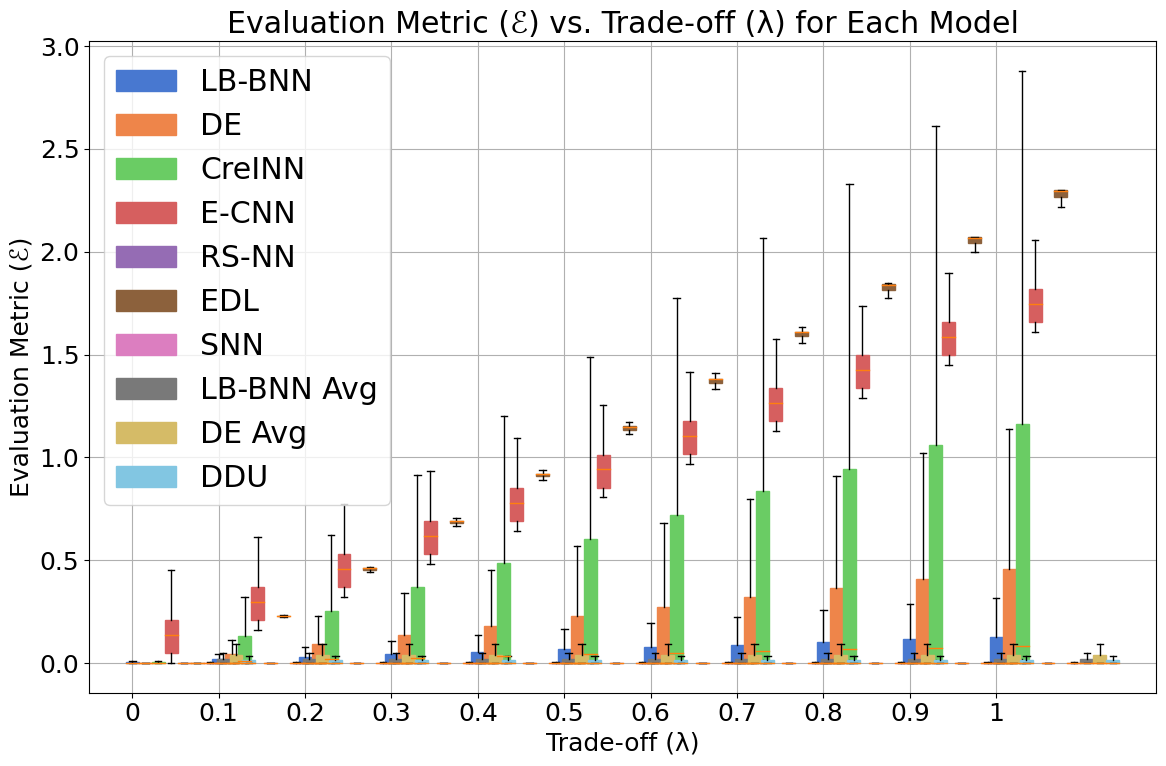

In [135]:
# Plot Evaluation Metric for different values of \lambda
palette = sns.color_palette("muted", n_colors=len(eval_metrics))

# Plot box plot for each model
plt.figure(figsize=(12, 8))
for i, (model_name, lamda_metrics) in enumerate(eval_metrics.items()):
    model_evals = [lamda_metrics[lamda] for lamda in lambda_values]
    bp = plt.boxplot(model_evals, positions=[lambda_val + i * 0.15 for lambda_val in range(len(lambda_values))], widths=0.15, showfliers=False, patch_artist=True)
    
    for box in bp['boxes']:
        box.set_color(palette[i])

# Create custom legend patches
legend_patches = [mpatches.Patch(color=palette[i], label=model_name) for i, model_name in enumerate(eval_metrics.keys())]

# Add legend with custom patches
plt.legend(handles=legend_patches, loc='upper left', fontsize='large')

plt.xlabel('Trade-off (\u03bb)')
plt.ylabel('Evaluation Metric (\u2130)')
plt.title('Evaluation Metric (\u2130) vs. Trade-off (\u03bb) for Each Model')
plt.grid(True)
plt.xticks(ticks=range(len(lambda_values)), labels=[str(l) for l in lambda_values])
plt.tight_layout()
plt.show()


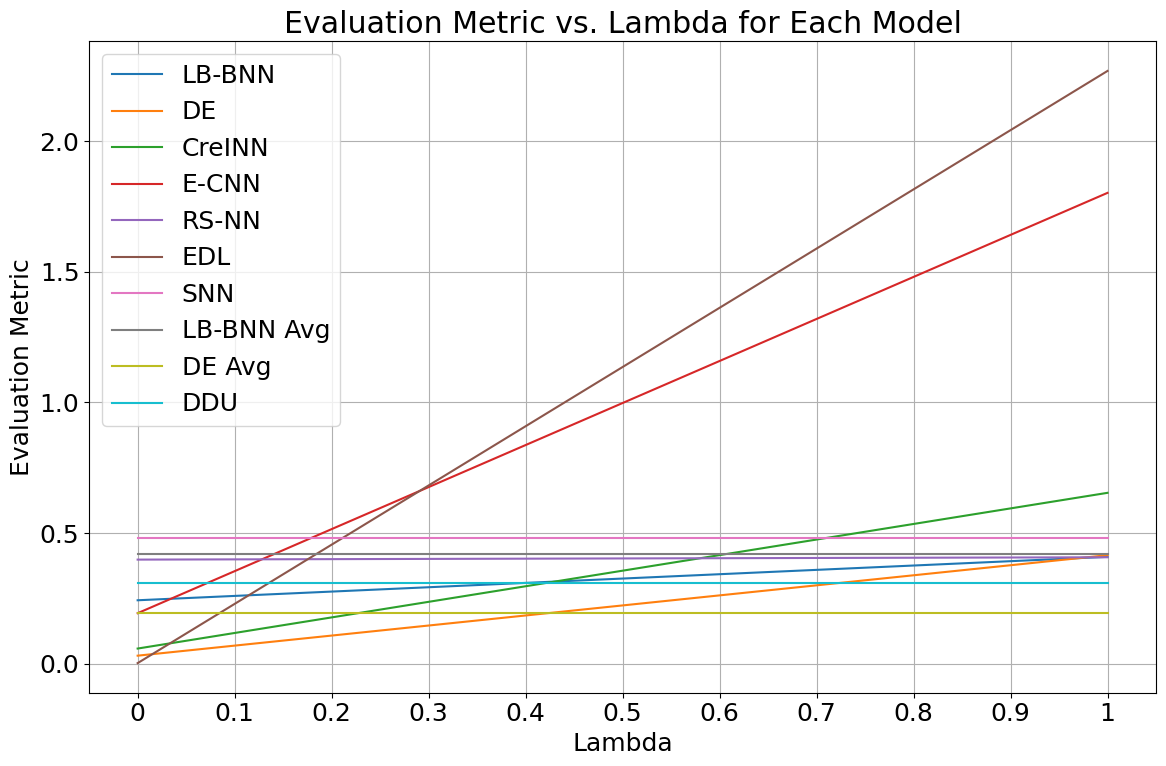

In [136]:
# Line plot for Evaluation Metric vs non-specificity
# Define a muted color palette
palette = sns.color_palette("muted", n_colors=len(eval_metrics))

# Plot box plot for each model
plt.figure(figsize=(12, 8))
for i, model_name in enumerate(eval_metrics):
    plt.plot(np.mean(np.array(list(eval_metrics[model_name].values())), axis=-1), label=model_name)

plt.legend()

plt.xlabel('Lambda')
plt.ylabel('Evaluation Metric')
plt.title('Evaluation Metric vs. Lambda for Each Model')
# plt.xlim([-0.8,1.5])
plt.grid(True)
plt.xticks(ticks=range(len(lambda_values)), labels=[str(l) for l in lambda_values])
plt.tight_layout()
plt.show()


## ABLATION STUDY

## ABLATION: KL divergence vs JS divergence

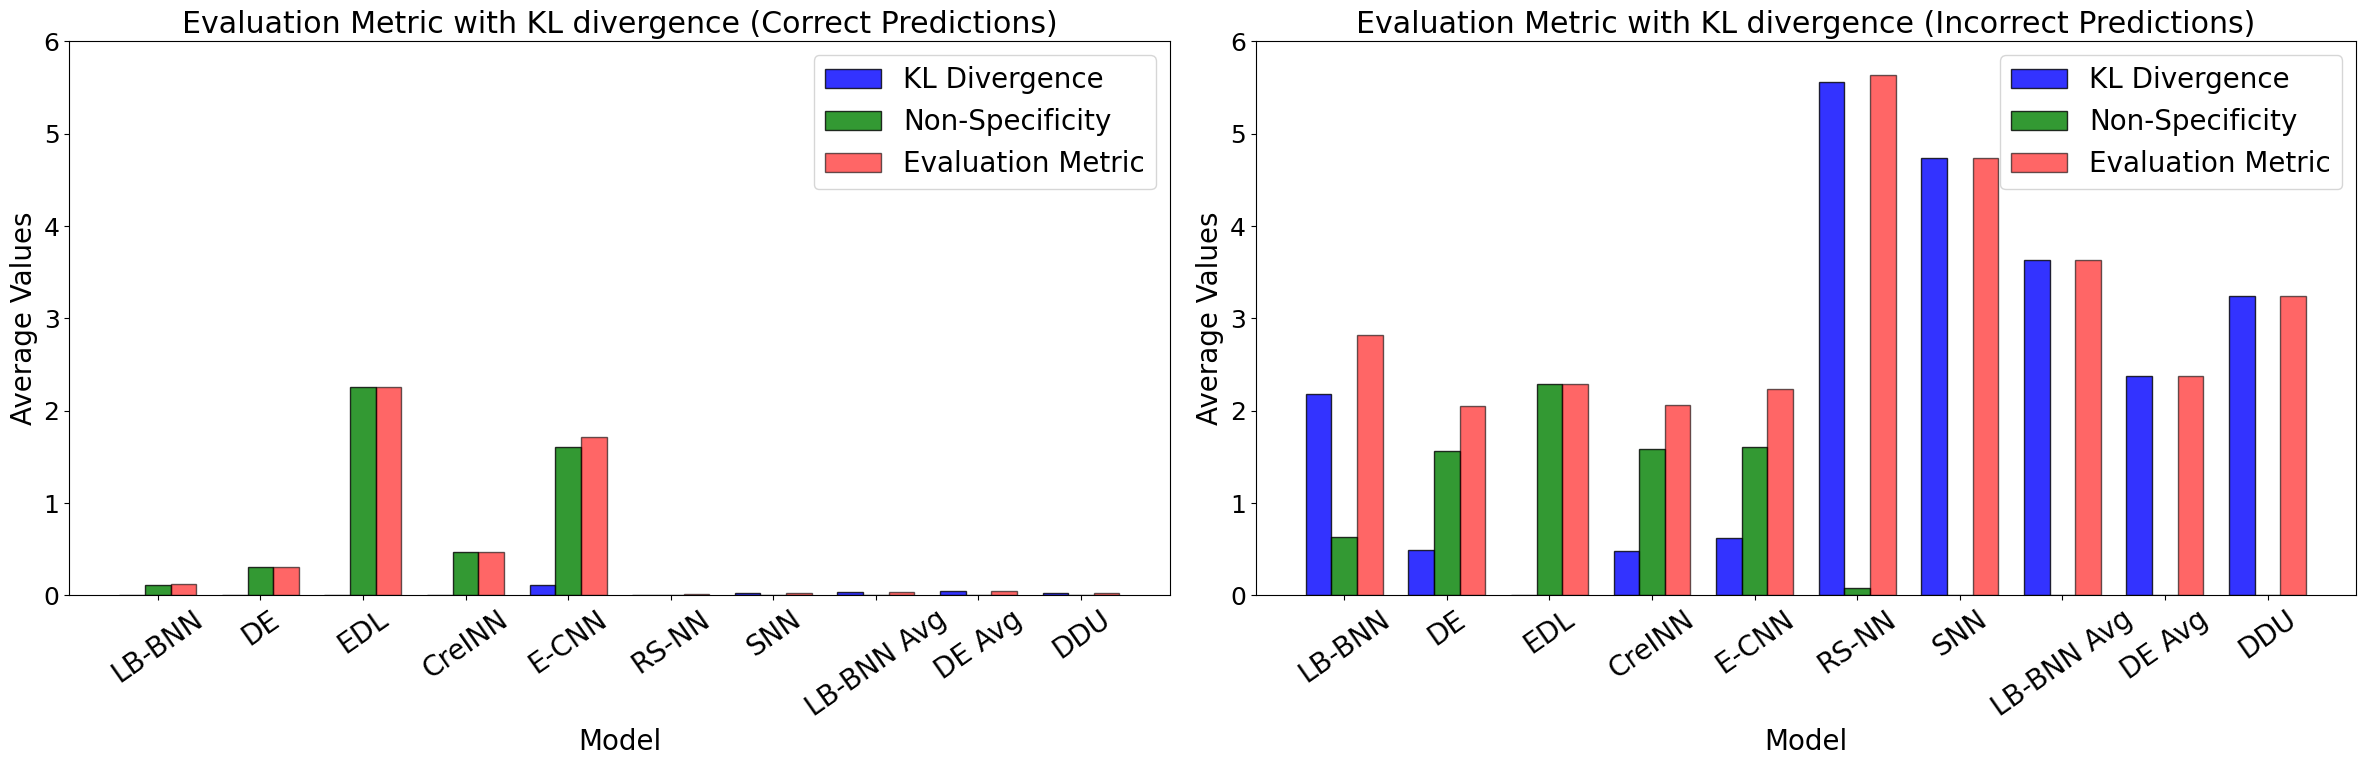

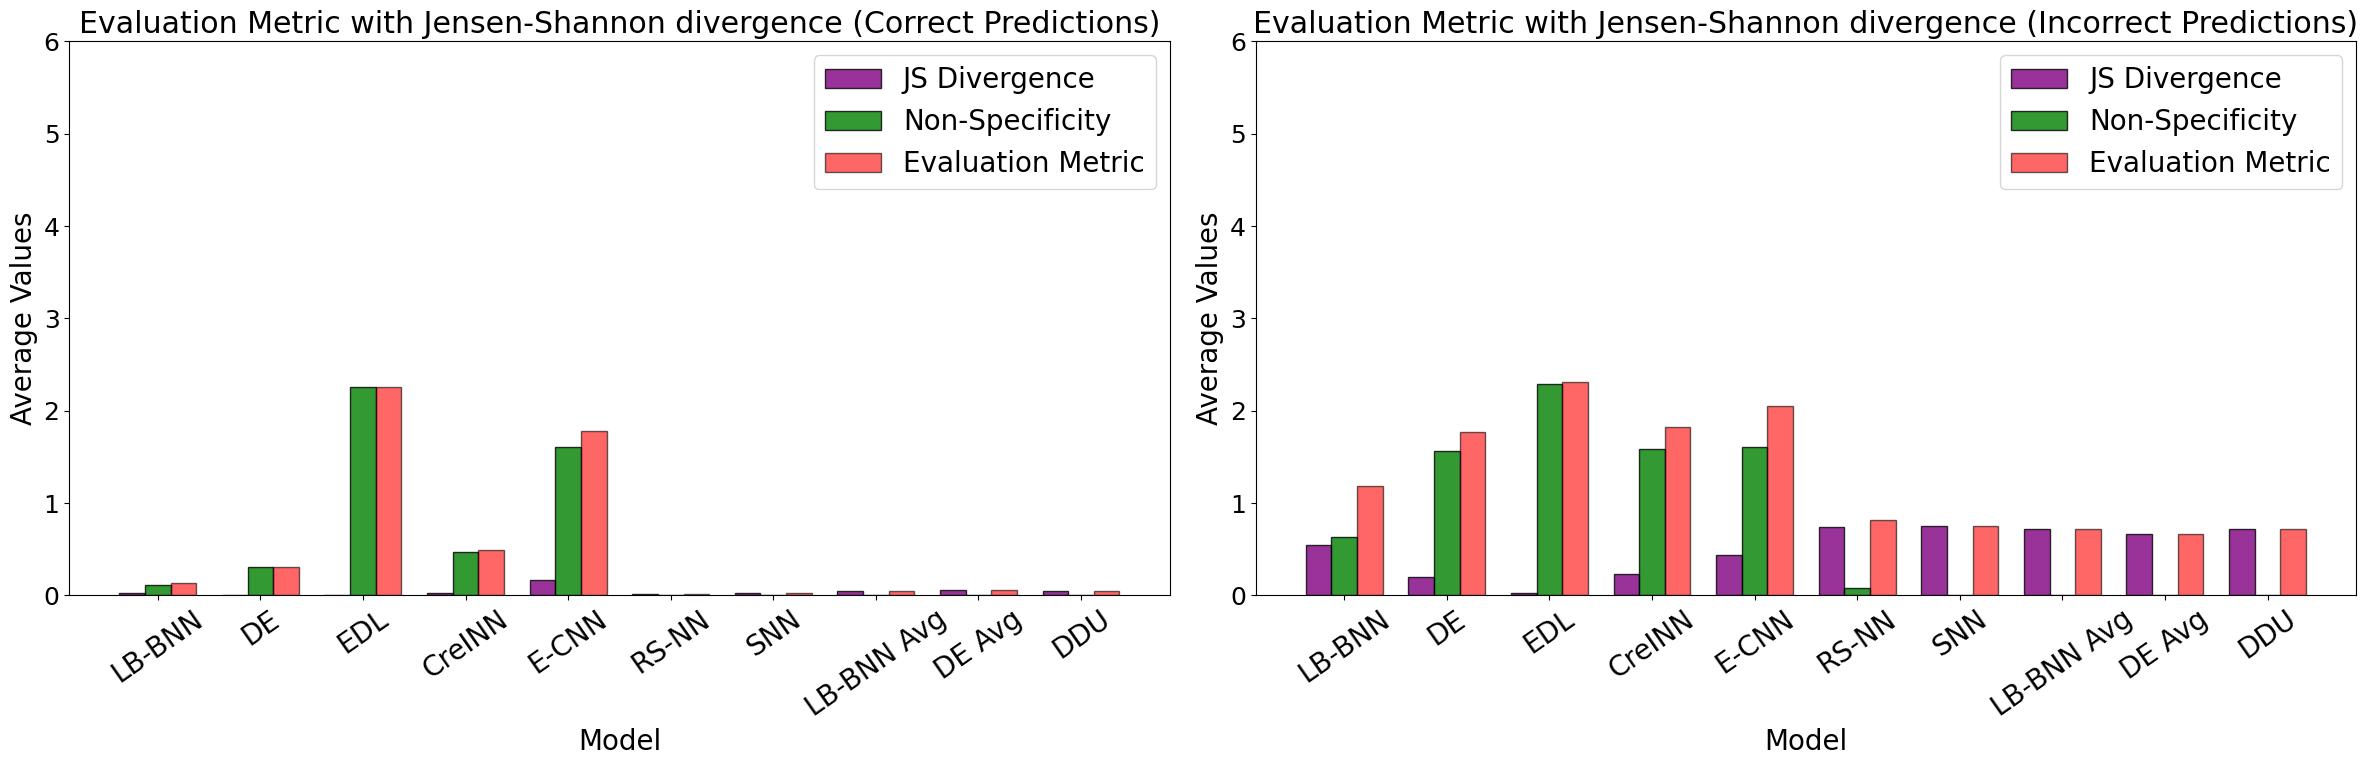

In [137]:
desired_order = ["LB-BNN", "DE", "EDL", "CreINN", "E-CNN", "RS-NN", "SNN", "LB-BNN Avg", "DE Avg", "DDU"]
plt.rcParams.update({'font.size': 18})

# Function to create bar plots
def create_bar_plots(axes, df_kl, df_ns, title, type_pred):
    bar_width = 0.25
    x = np.arange(len(desired_order))

    df_means = df_kl[df_kl['Type'] == type_pred].groupby('Model').mean(numeric_only=True)
    df_spec_means = df_ns[df_ns['Type'] == type_pred].groupby('Model').mean(numeric_only=True)

    # Calculate combined metric
    df_means['combined'] = df_means['KL Divergence'] + df_spec_means['Non-Specificity']

    # Bar plots for KL Divergence, Non-Specificity, and Combined Metric
    axes.bar(x - bar_width, df_means['KL Divergence'].loc[desired_order], 
             width=bar_width, color='blue', alpha=0.8, edgecolor='black', label='KL Divergence')
    axes.bar(x, df_spec_means['Non-Specificity'].loc[desired_order], 
             width=bar_width, color='green', alpha=0.8, edgecolor='black', label='Non-Specificity')
    axes.bar(x + bar_width, df_means['combined'].loc[desired_order], 
             width=bar_width, color='red', alpha=0.6, edgecolor='black', label='Evaluation Metric')

    axes.set_title(title)
    axes.set_xlabel('Model', fontsize=20)
    axes.set_ylabel('Average Values', fontsize=20)
    axes.set_xticks(x)
    axes.set_xticklabels(desired_order, rotation=35, fontsize=20)
    axes.legend(fontsize=20)
    
    axes.set_ylim(0, 6)

fig, axes = plt.subplots(1, 2, figsize=(24, 8))
create_bar_plots(axes[0], df_kl, df_spec, 'Evaluation Metric with KL divergence (Correct Predictions)', 'Correct')
create_bar_plots(axes[1], df_kl, df_spec, 'Evaluation Metric with KL divergence (Incorrect Predictions)', 'Incorrect')

plt.tight_layout()
plt.show()

# JS Divergence plots
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

def create_js_bar_plots(axes, df_js, df_ns2, title, type_pred):
    bar_width = 0.25
    x = np.arange(len(desired_order))

    df_js_means = df_js[df_js['Type'] == type_pred].groupby('Model').mean(numeric_only=True)
    df_spec_means_2 = df_ns2[df_ns2['Type'] == type_pred].groupby('Model').mean(numeric_only=True)

    # Calculate evaluation metric
    df_js_means['e'] = df_js_means['JS Divergence'] + df_spec_means_2['Non-Specificity']

    # Bar plots for JS Divergence, Non-Specificity, and Evaluation Metric
    axes.bar(x - bar_width, df_js_means['JS Divergence'].loc[desired_order], 
             width=bar_width, color='purple', alpha=0.8, edgecolor='black', label='JS Divergence')
    axes.bar(x, df_spec_means_2['Non-Specificity'].loc[desired_order], 
             width=bar_width, color='green', alpha=0.8, edgecolor='black', label='Non-Specificity')
    axes.bar(x + bar_width, df_js_means['e'].loc[desired_order], 
             width=bar_width, color='red', alpha=0.6, edgecolor='black', label='Evaluation Metric')

    axes.set_title(title)
    axes.set_xlabel('Model', fontsize=20)
    axes.set_ylabel('Average Values', fontsize=20)
    axes.set_xticks(x)
    axes.set_xticklabels(desired_order, rotation=35, fontsize=20)
    axes.legend(fontsize=20)

    axes.set_ylim(0, 6)

create_js_bar_plots(axes[0], df_js, df_spec, 'Evaluation Metric with Jensen-Shannon divergence (Correct Predictions)', 'Correct')
create_js_bar_plots(axes[1], df_js, df_spec, 'Evaluation Metric with Jensen-Shannon divergence (Incorrect Predictions)', 'Incorrect')

plt.tight_layout()
plt.show()

## ABLATION: KL divergence/JS divergence vs. Non-Specificity

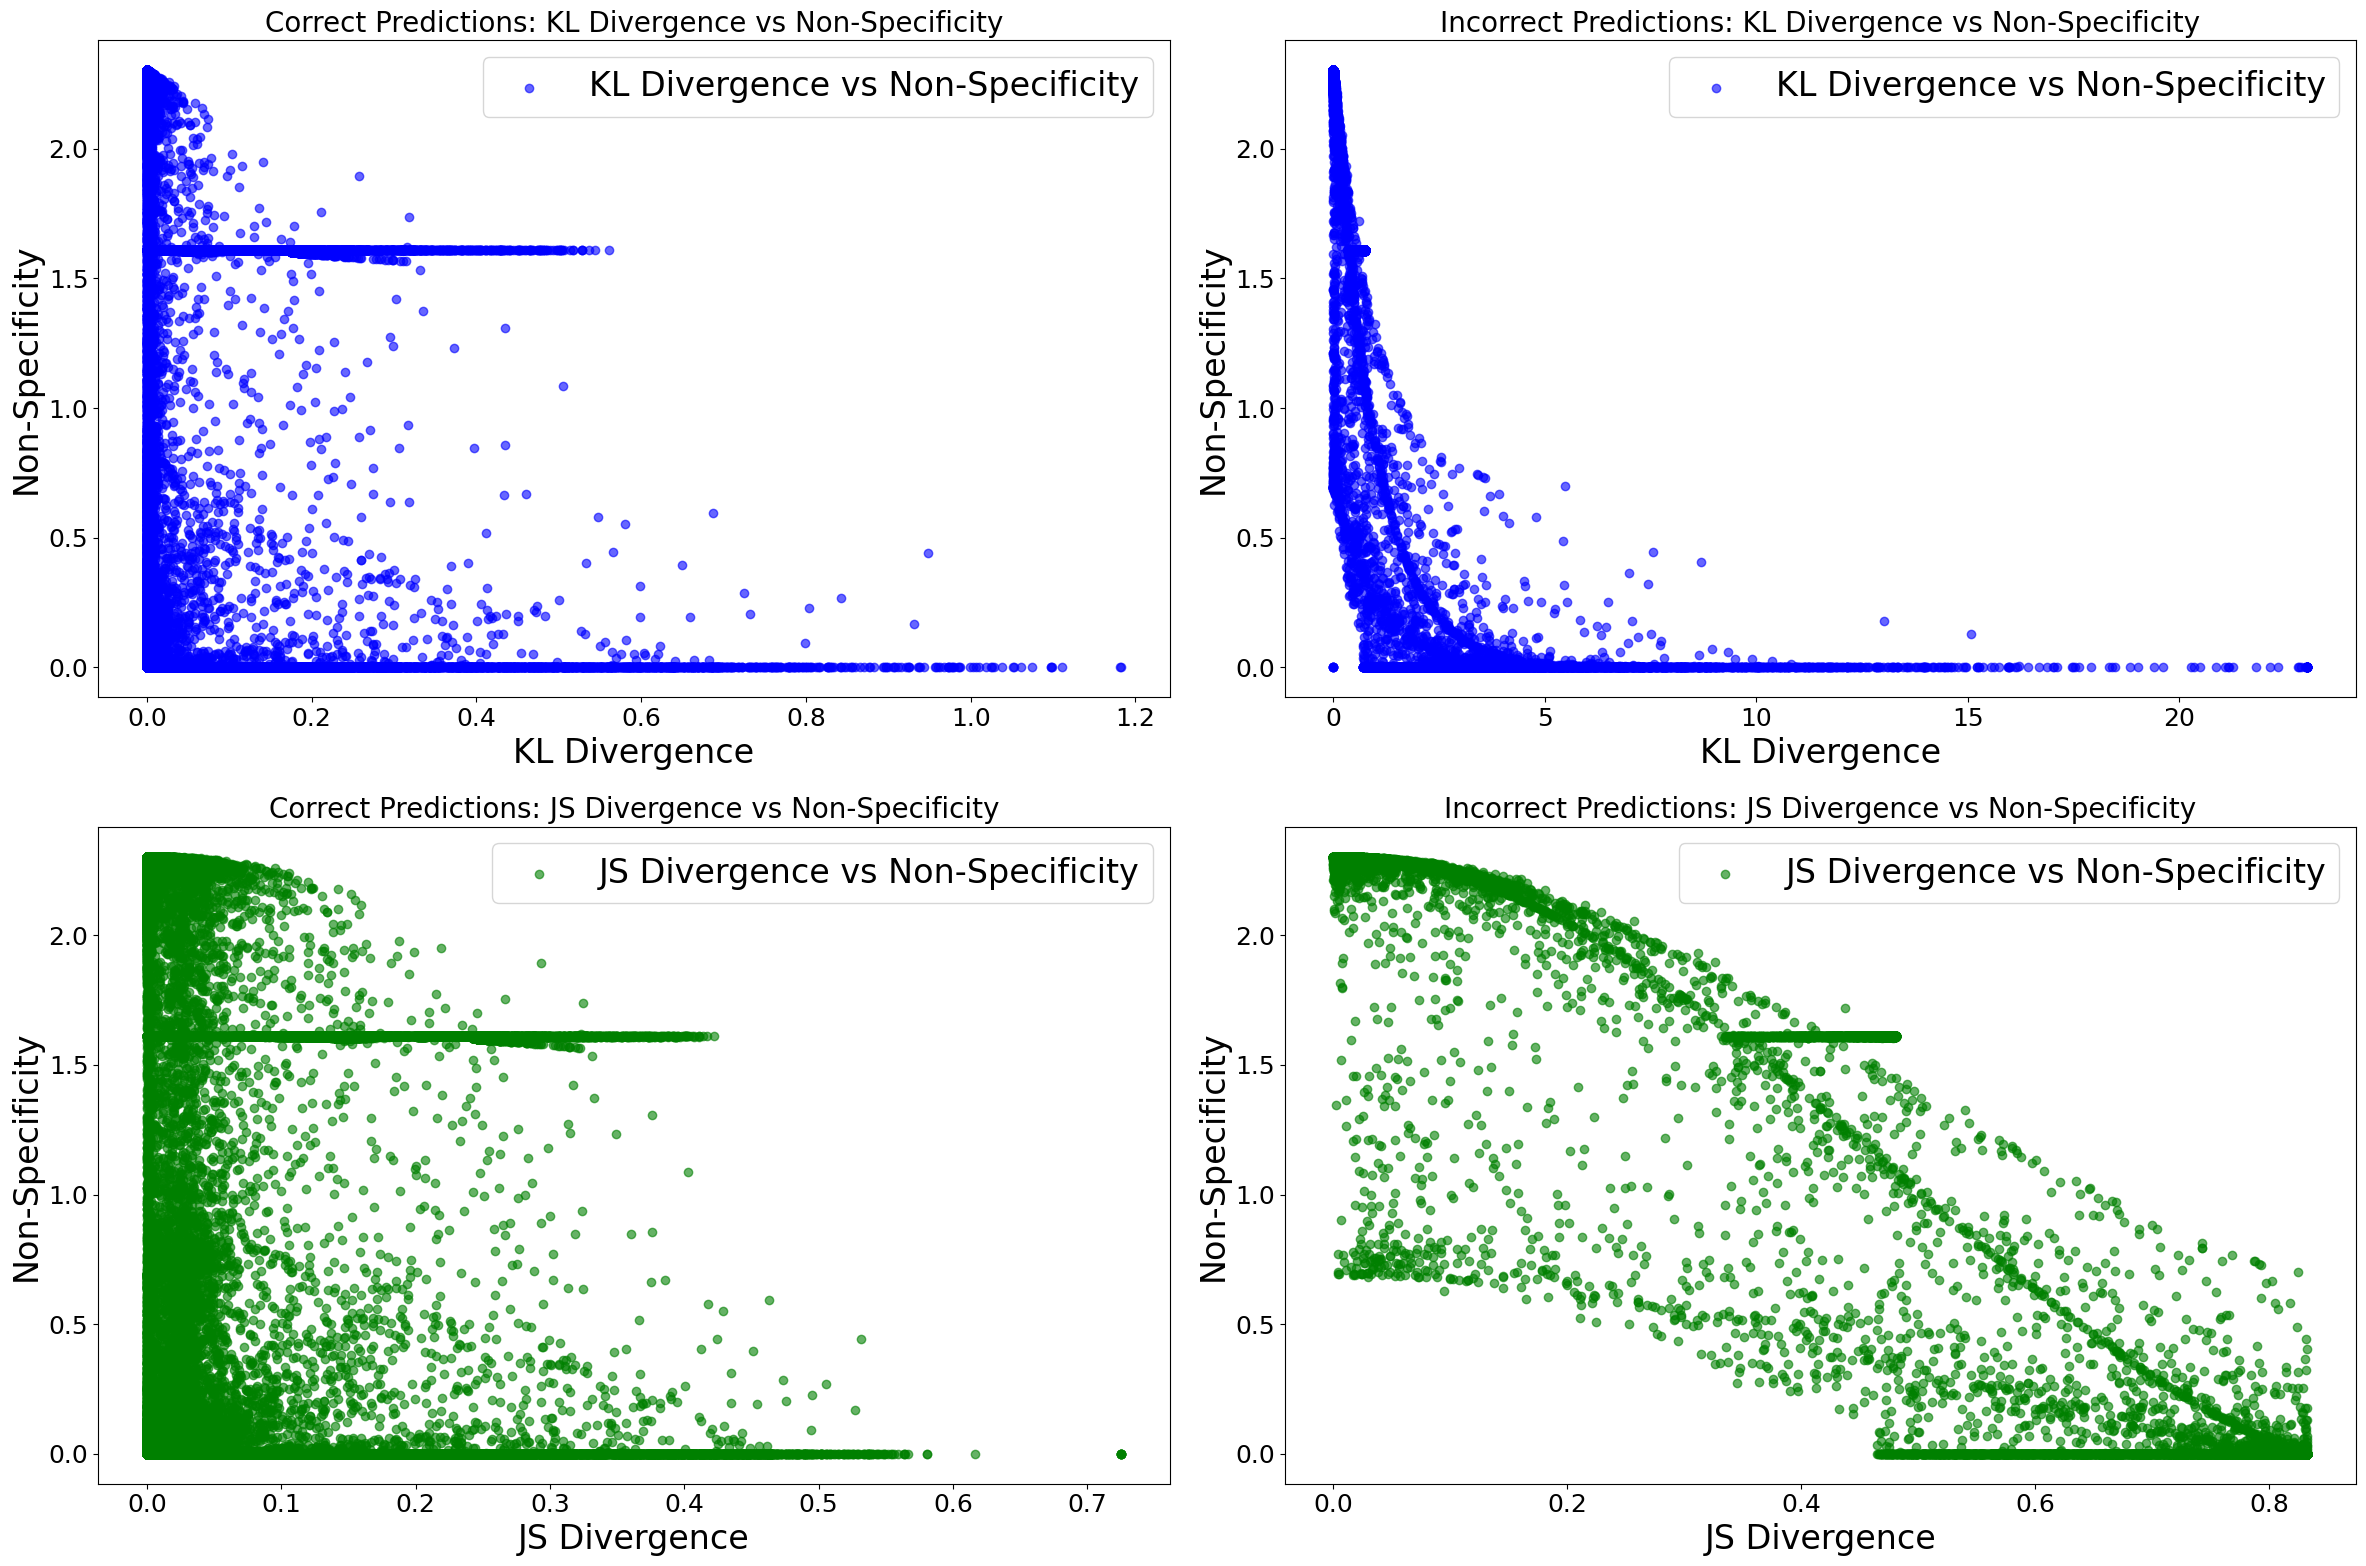

In [138]:
# Scatter Plot of KL vs NS and JS vs NS
df_kl_correct = df_kl[df_kl['Type'] == 'Correct']
df_kl_incorrect = df_kl[df_kl['Type'] == 'Incorrect']
df_js_correct = df_js[df_js['Type'] == 'Correct']
df_js_incorrect = df_js[df_js['Type'] == 'Incorrect']
df_spec_correct = df_spec[df_spec['Type'] == 'Correct']
df_spec_incorrect = df_spec[df_spec['Type'] == 'Incorrect']

fig, axes = plt.subplots(2, 2, figsize=(24, 16))
plt.rcParams.update({'font.size': 18})


axes[0, 0].scatter(df_kl_correct['KL Divergence'], df_spec_correct['Non-Specificity'], alpha=0.6, color='blue', label='KL Divergence vs Non-Specificity')
axes[0, 0].set_title('Correct Predictions: KL Divergence vs Non-Specificity',fontsize=20)
axes[0, 0].set_xlabel('KL Divergence',fontsize=24)
axes[0, 0].set_ylabel('Non-Specificity',fontsize=24)
axes[0, 0].legend(fontsize=24)

axes[0, 1].scatter(df_kl_incorrect['KL Divergence'], df_spec_incorrect['Non-Specificity'], alpha=0.6, color='blue', label='KL Divergence vs Non-Specificity')
axes[0, 1].set_title('Incorrect Predictions: KL Divergence vs Non-Specificity',fontsize=20)
axes[0, 1].set_xlabel('KL Divergence',fontsize=24)
axes[0, 1].set_ylabel('Non-Specificity',fontsize=24)
axes[0, 1].legend(fontsize=24)

axes[1, 0].scatter(df_js_correct['JS Divergence'], df_spec_correct['Non-Specificity'], alpha=0.6, color='green', label='JS Divergence vs Non-Specificity')
axes[1, 0].set_title('Correct Predictions: JS Divergence vs Non-Specificity',fontsize=20)
axes[1, 0].set_xlabel('JS Divergence',fontsize=24)
axes[1, 0].set_ylabel('Non-Specificity',fontsize=24)
axes[1, 0].legend(fontsize=24)

axes[1, 1].scatter(df_js_incorrect['JS Divergence'], df_spec_incorrect['Non-Specificity'], alpha=0.6, color='green', label='JS Divergence vs Non-Specificity')
axes[1, 1].set_title('Incorrect Predictions: JS Divergence vs Non-Specificity',fontsize=20)
axes[1, 1].set_xlabel('JS Divergence',fontsize=24)
axes[1, 1].set_ylabel('Non-Specificity',fontsize=24)
axes[1, 1].legend(fontsize=24)

plt.tight_layout()
plt.show()

## ABLATION: Prediction Sample size vs Evaluation Metric

In [139]:
# Load saved evaluation metric for different number of samples (LB-BNN) and ensembles (DE)
eval_lbbnn_values_50 = load_npy('ablation_study', 'eval_lbbnn_values_50.npy')
eval_lbbnn_values_100 = load_npy('ablation_study', 'eval_lbbnn_values_100.npy')
eval_lbbnn_values_150 = load_npy('ablation_study', 'eval_lbbnn_values_150.npy')
eval_lbbnn_values_200 = load_npy('ablation_study', 'eval_lbbnn_values_200.npy')
eval_lbbnn_values_300 = load_npy('ablation_study', 'eval_lbbnn_values_300.npy')
eval_lbbnn_values_400 = load_npy('ablation_study', 'eval_lbbnn_values_400.npy')
eval_lbbnn_values_500 = load_npy('ablation_study', 'eval_lbbnn_values_500.npy')

eval_de_values_5 = load_npy('ablation_study', 'eval_de_values_5.npy')
eval_de_values_10 = load_npy('ablation_study', 'eval_de_values_10.npy')
eval_de_values_15 = load_npy('ablation_study', 'eval_de_values_15.npy')
eval_de_values_20 = load_npy('ablation_study', 'eval_de_values_20.npy')
eval_de_values_25 = load_npy('ablation_study', 'eval_de_values_25.npy')
eval_de_values_30 = load_npy('ablation_study', 'eval_de_values_30.npy')

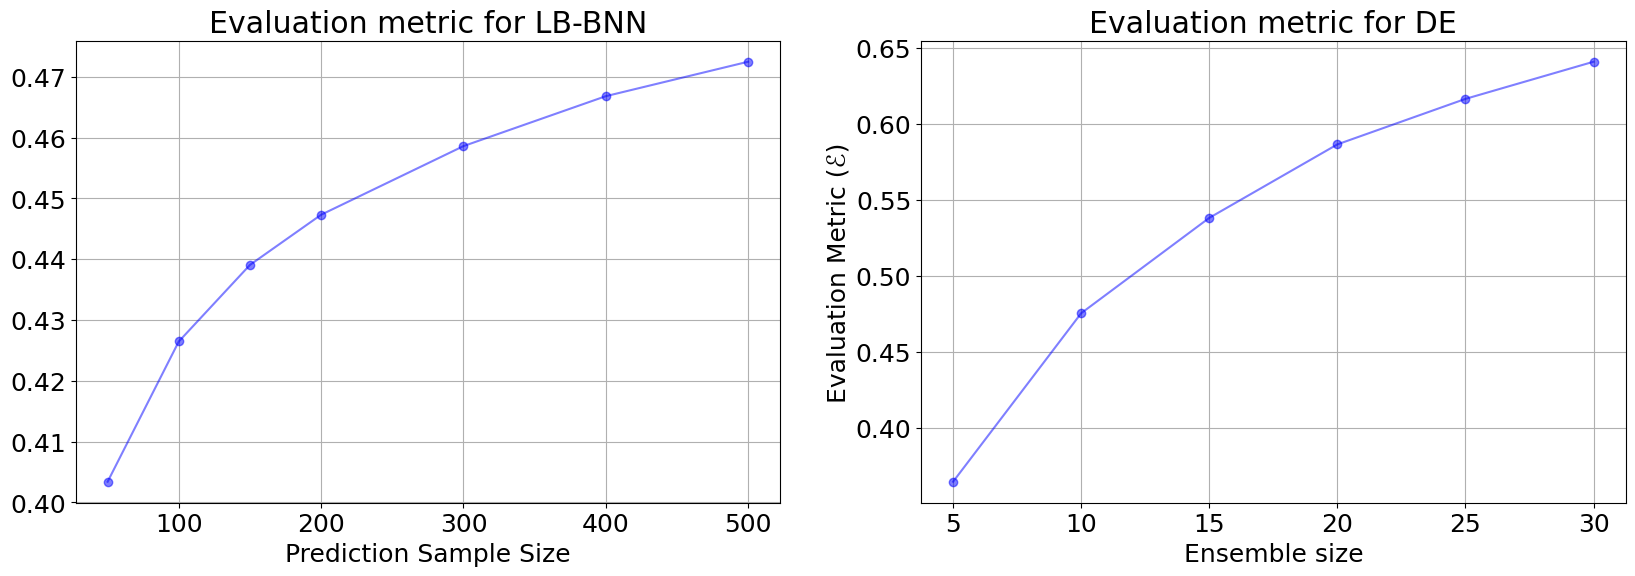

In [140]:
# Plot evaluation metric for different number of samples (LB-BNN) and ensembles (DE)
lb_bnn_sample_sizes = [50, 100, 150, 200, 300, 400, 500]
de_sample_sizes = [5, 10, 15, 20, 25, 30]

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
all_vals = np.stack([eval_lbbnn_values_50, eval_lbbnn_values_100, eval_lbbnn_values_150, eval_lbbnn_values_200, eval_lbbnn_values_300, eval_lbbnn_values_400, eval_lbbnn_values_500])
axs[0].plot(lb_bnn_sample_sizes, np.mean(all_vals, axis=-1), marker='o', color="b", alpha=0.5, label=f'LB-BNN Sample 50')
axs[0].set_xlabel('Prediction Sample Size')
axs[1].set_ylabel('Evaluation Metric (\u2130)')
axs[0].set_title('Evaluation metric for LB-BNN')
axs[0].grid(True)

all_vals_de = np.stack([eval_de_values_5, eval_de_values_10, eval_de_values_15, eval_de_values_20, eval_de_values_25, eval_de_values_30])
axs[1].plot(de_sample_sizes, np.mean(all_vals_de, axis=-1), marker='o', color="b", alpha=0.5, label=f'DE Sample 50')

axs[1].set_xlabel('Ensemble size')
axs[1].set_ylabel('Evaluation Metric (\u2130)')
axs[1].set_title('Evaluation metric for DE')
axs[1].grid(True)

plt.show()


## ABLATION: Credal Set Size vs. Non-Specificity

In [141]:
# Plot credal set size vs non-specificity
model_credal_widths = {}

# Plot maximum and minimum values for all models
for i, (model_name, model_vertices) in enumerate(models_vertices.items()):
    model_credal_widths[model_name] = []
    for j,v in enumerate(model_vertices):
        max_value_index = np.arange(num_classes)*2
        min_value_index = np.arange(num_classes)*2+1
        pred_class = models[model_name][j]
        max_values = v[max_value_index, np.arange(num_classes)]
        min_values = v[min_value_index, np.arange(num_classes)]
        model_credal_widths[model_name].append(np.mean(max_values-min_values))

    model_credal_widths[model_name] = np.array(model_credal_widths[model_name])        

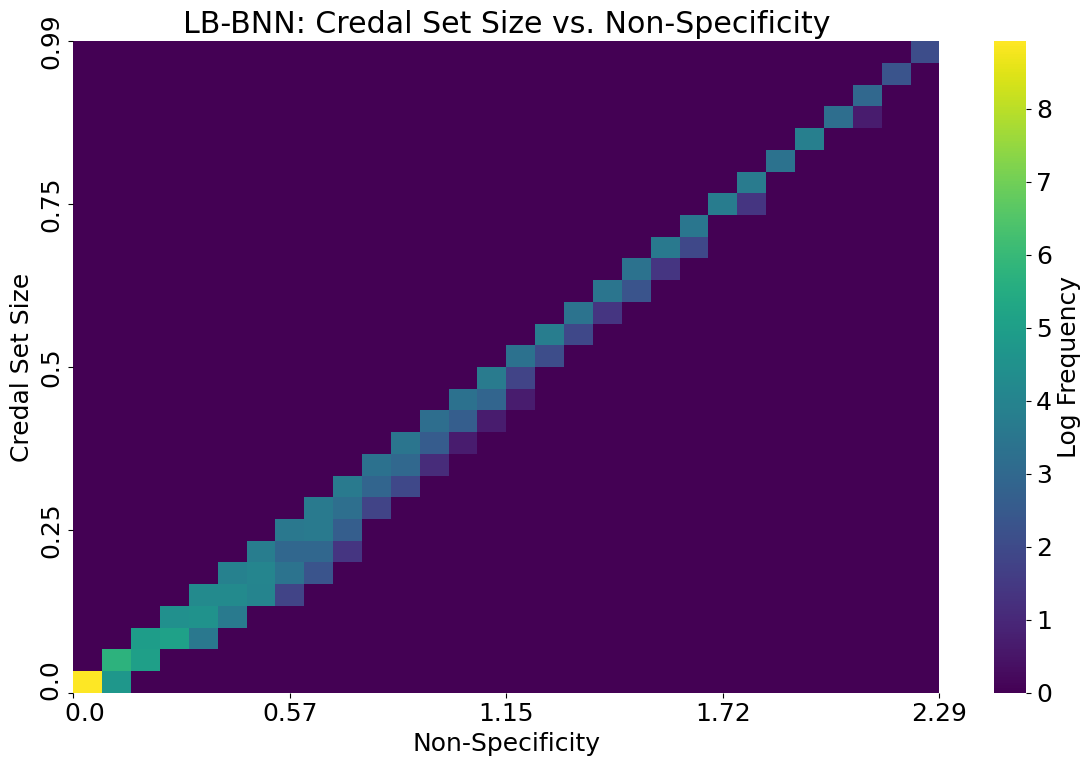

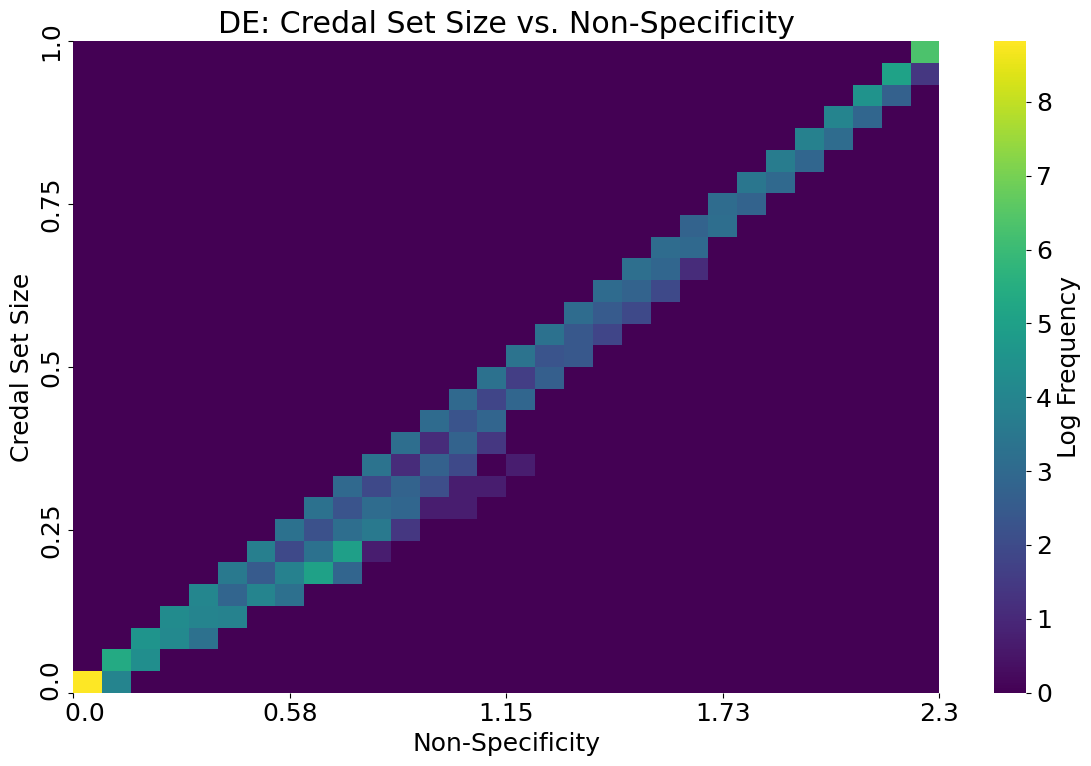

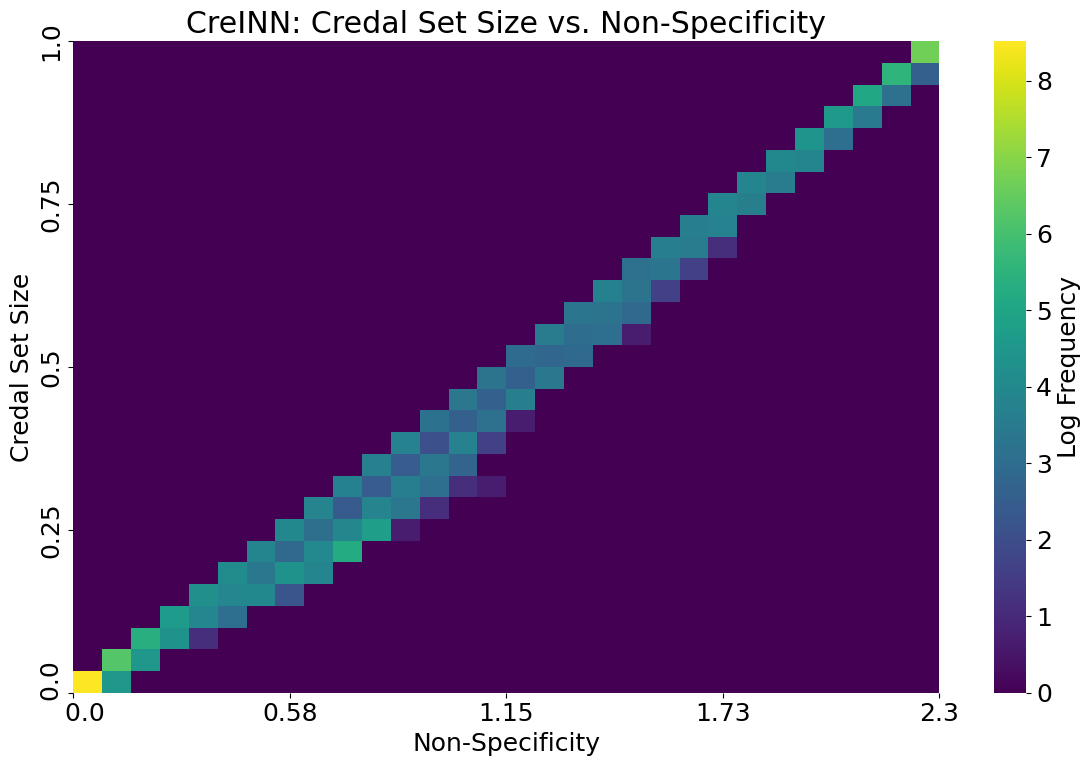

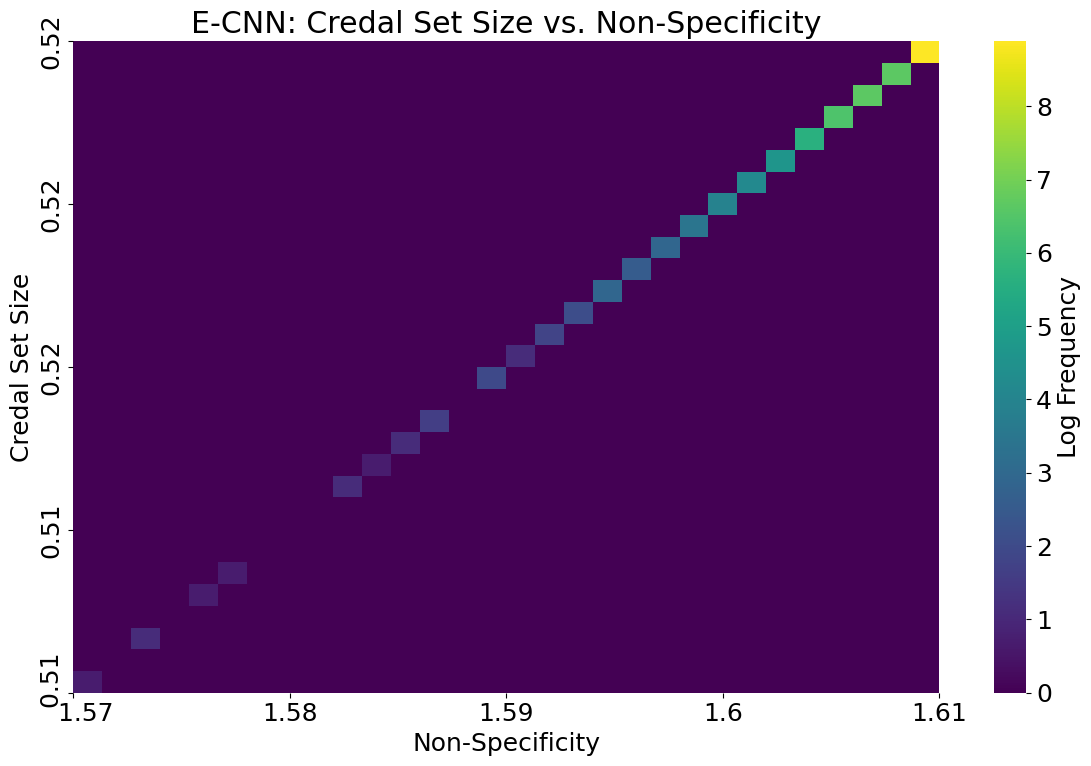

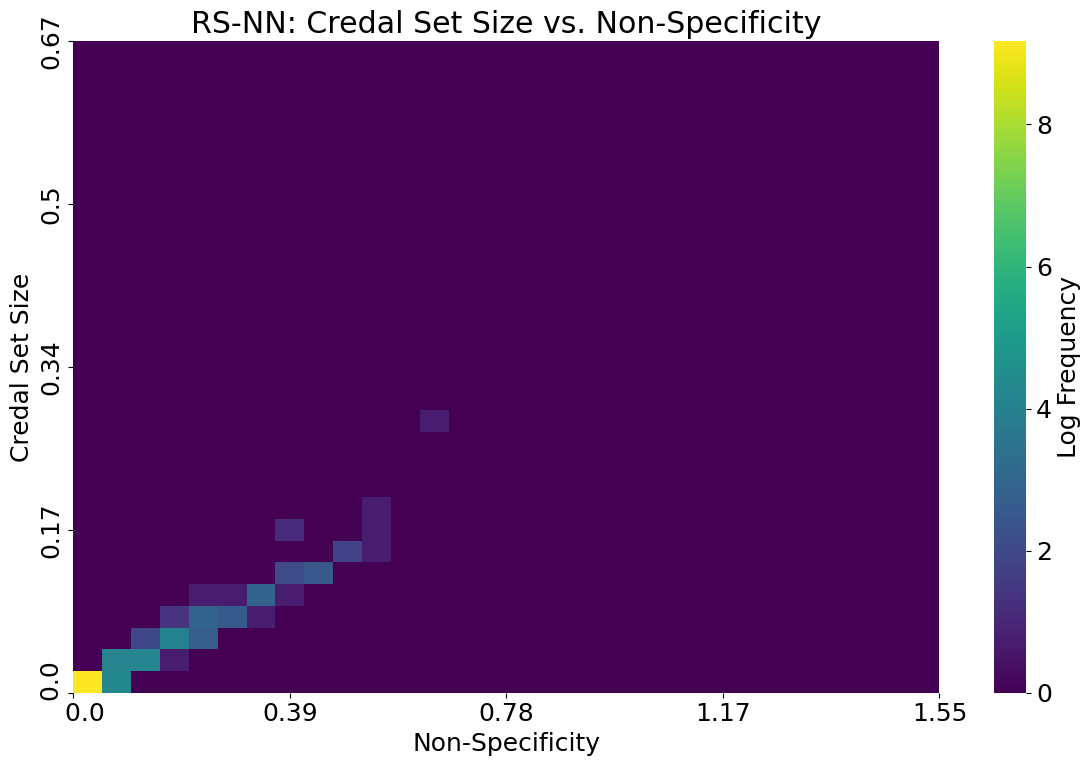

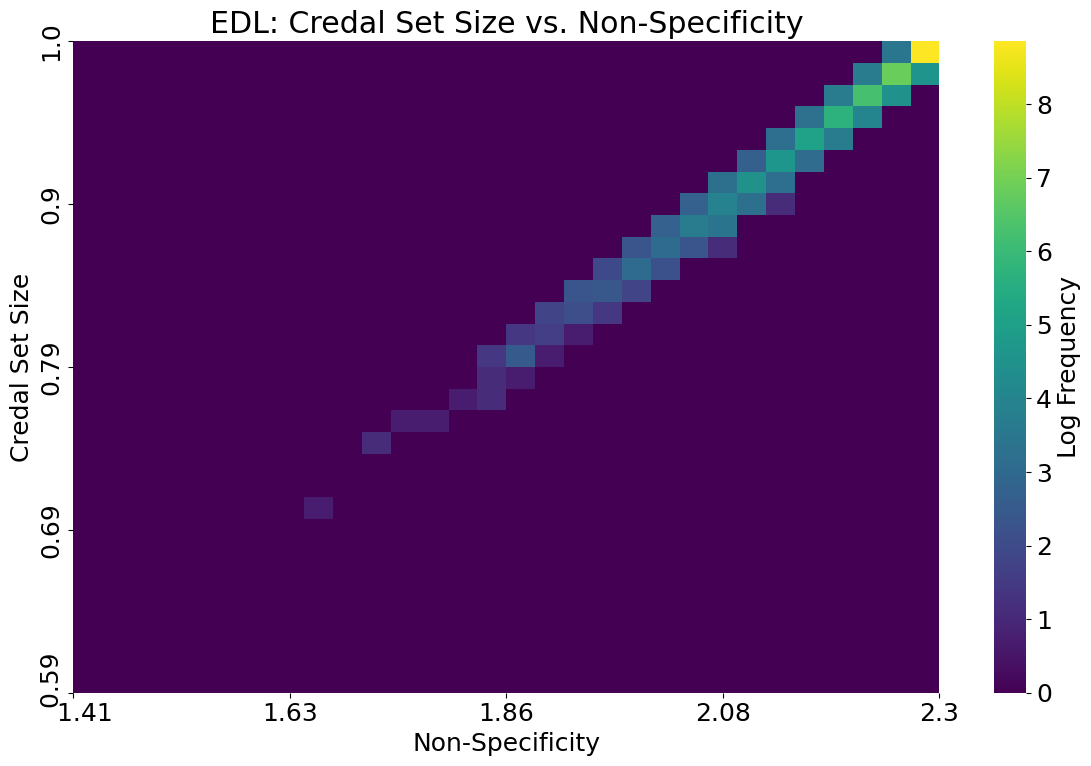

In [142]:
for model_name in model_credal_widths:
    fig, ax = plt.subplots(figsize=(12, 8))
    base = np.e
    hist_vals = np.emath.logn(base, np.histogram2d(non_specificity[model_name], model_credal_widths[model_name], bins=30)[0].T + 1e-31)
    
    hist_vals = np.clip(hist_vals, a_min=0, a_max=None)
    
    col_name = "viridis"
    color_palette = sns.color_palette(col_name, as_cmap=True)
    # Create heatmaps with normalized color scale
    sns.heatmap(data=hist_vals, cmap=color_palette, cbar=True, cbar_kws={'label': 'Log Frequency'}, vmin=0, vmax=np.max(hist_vals), ax=ax)
    
    ax.set_title(f"{model_name}: Credal Set Size vs. Non-Specificity")
    # Remove bin sizes on axes
    ax.set_xticks(np.linspace(0,30,5))
    x_tick_labels = list(np.round(np.linspace(np.min(non_specificity[model_name]),np.max(non_specificity[model_name]),5), 2))
    x_tick_labels[0] = f"   {x_tick_labels[0]}"
    ax.set_xticklabels(x_tick_labels, rotation = 0)
    
    ax.set_yticks(np.linspace(0,30,5))
    y_tick_labels = list(np.round(np.linspace(np.min(model_credal_widths[model_name]),np.max(model_credal_widths[model_name]),5), 2))
    y_tick_labels[0] = f"   {y_tick_labels[0]}"
    ax.set_yticklabels(y_tick_labels)
    
    ax.set_xlabel("Non-Specificity")
    ax.invert_yaxis()
    ax.set_ylabel("Credal Set Size")  
    plt.tight_layout()
    plt.show()

In [143]:
edl = edl_alpha_pred_100_lower_probs[:,:10]
lbbnn = lbbnn_100_lower_probs[:,:10]
de = de_15_lower_probs[:,:10]
creinn = creinn_lower_probs[:,:10]
ecnn = ecnn_preds[:,:10]
rsnn = rsnn_preds[:,:10]

In [144]:
lbbnn.shape, de.shape, edl.shape,creinn.shape,ecnn.shape,rsnn.shape,cnn_preds.shape,lbbnn_cifar10_bmaveraged.shape,de_cifar10_averaged.shape,ddu_preds.shape

((10000, 10),
 (10000, 10),
 (10000, 10),
 (10000, 10),
 (10000, 10),
 (10000, 10),
 (10000, 10),
 (10000, 10),
 (10000, 10),
 (10000, 10))

In [145]:
import numpy as np
from scipy.optimize import minimize

# Stack the lower probabilities of all models into a single 3D array
lower_probs_2d = np.array([
    lbbnn,
    de,
    edl,
    creinn,
    ecnn,
    rsnn
]) 
model_names = [
    "LB-BNN", "DE", "EDL", "CreINN", "E-CNN", "RS-NN"
]

uncertainty_results = {}

for i in range(lower_probs_2d.shape[0]):  # Iterate over each model
    lower_probs_2d[i] /= lower_probs_2d[i].sum(axis=1, keepdims=True)  # Normalize each sample's probabilities

# Function to compute lower bound (minimizing entropy)
def compute_lower_bound(lower_probs):
    C = len(lower_probs)  # Number of classes
    initial_guess = np.maximum(lower_probs, 1e-10)  # Avoid zero probabilities

    # Objective function: negative entropy (to minimize)
    def entropy(q):
        return -np.sum(q * np.log2(q + 1e-10))  # Add small value to avoid log(0)

    # Constraints: sum(qi) = 1
    constraints = [{'type': 'eq', 'fun': lambda q: np.sum(q) - 1}]  
    # Bounds: Each qi >= lower_probs
    bounds = [(lower_probs[i], 1) for i in range(C)]  

    # Minimize negative entropy to get the lower bound of entropy
    result = minimize(entropy, initial_guess, method='SLSQP', constraints=constraints, bounds=bounds)

    if result.success:
        lower_entropy = -result.fun  # Get positive entropy value
        return lower_entropy, result.x
    else:
        print("Lower bound optimization failed.")
        return None, None  # Handle this case appropriately

# Function to compute upper bound (maximizing entropy)
def compute_upper_bound(lower_probs):
    C = len(lower_probs)  # Number of classes
    # Set the initial guess to a uniform distribution
    initial_guess = np.ones(C) / C  # Uniform distribution as an example

    # Objective function: negative entropy (to minimize)
    def entropy(q):
        return -np.sum(q * np.log2(q + 1e-10))  # Add small value to avoid log(0)

    # Constraints: sum(qi) = 1
    constraints = [{'type': 'eq', 'fun': lambda q: np.sum(q) - 1}]  
    # Bounds: Allow probabilities to be any valid value in [0, 1]
    bounds = [(0, 1) for i in range(C)]  # Flexible bounds

    # Minimize negative entropy to maximize the entropy (upper bound)
    result = minimize(entropy, initial_guess, method='SLSQP', constraints=constraints, bounds=bounds)

    if result.success:
        upper_entropy = -result.fun  # Get positive entropy value
        return upper_entropy, result.x
    else:
        print("Upper bound optimization failed.")
        return None, None  # Handle this case appropriately

# Results storage
lower_bounds_results = {}
upper_bounds_results = {}

# Compute bounds and uncertainty for each model and sample
num_models, num_samples, num_classes = lower_probs_2d.shape
for model_idx, model_name in enumerate(model_names):
    lower_entropies = []
    upper_entropies = []
    
    for sample_idx in range(num_samples):
        lower_probs_row = lower_probs_2d[model_idx, sample_idx, :]  # Access each model's probabilities for the sample
        
        # Compute lower and upper bounds
        lowerH, _ = compute_lower_bound(lower_probs_row)
        upperH, _ = compute_upper_bound(lower_probs_row)
        
        if lowerH is not None and upperH is not None:
            lower_entropies.append(lowerH)
            upper_entropies.append(upperH)

    # Store results for the model
    lower_bounds_results[f"Model {model_name}"] = np.array(lower_entropies)
    upper_bounds_results[f"Model {model_name}"] = np.array(upper_entropies)

    # Calculate uncertainty
    uncertainty = np.array(lower_entropies) - np.array(upper_entropies)  # (10000,)
    uncertainty_results[f"Model {model_name}"] = uncertainty
    # if model_idx == 0:
    #     edl_uncertainty = uncertainty  # EDL
    # elif model_idx == 1:
    #     lbbnn_uncertainty = uncertainty  # LB-BNN
    # elif model_idx == 2:
    #     de_uncertainty = uncertainty  # DE
    # elif model_idx == 3:
    #     creinn_uncertainty = uncertainty  # CREINN


# Display the results
print("Lower Bounds Results:")
for model, lower_entropy_values in lower_bounds_results.items():
    print(f"{model}: Lower Entropy Mean = {np.mean(lower_entropy_values):.4f}, Values = {lower_entropy_values}")

print("\nUpper Bounds Results:")
for model, upper_entropy_values in upper_bounds_results.items():
    print(f"{model}: Upper Entropy Mean = {np.mean(upper_entropy_values):.4f}, Values = {upper_entropy_values}")

print("\nUncertainty Results:")
for model, uncertainty_values in uncertainty_results.items():
    print(f"{model}: Uncertainty Mean = {np.mean(uncertainty_values):.4f}, Values = {uncertainty_values}")


Lower Bounds Results:
Model LB-BNN: Lower Entropy Mean = -0.1227, Values = [-2.59283712e-04 -4.30164616e-08 -1.37513662e-02 ... -9.61777077e-05
 -3.06744982e-07 -5.89699156e-06]
Model DE: Lower Entropy Mean = -0.0610, Values = [-3.11025698e-08 -2.88530856e-08 -2.23755880e-05 ... -2.89577242e-08
 -2.88739444e-08 -2.88531234e-08]
Model EDL: Lower Entropy Mean = -0.1754, Values = [-5.00203053e-02 -2.88530833e-08 -2.88530833e-08 ... -1.54461794e-02
 -4.27188661e-02 -2.88530833e-08]
Model CreINN: Lower Entropy Mean = -0.2700, Values = [-0.01045958 -0.01994013 -0.00569112 ... -0.03225524 -0.01033701
 -0.02106637]
Model E-CNN: Lower Entropy Mean = -1.1534, Values = [-1.30502705 -1.13895645 -1.20510362 ... -1.3541416  -1.81965823
 -0.02028761]
Model RS-NN: Lower Entropy Mean = -0.0497, Values = [-2.88531375e-08 -2.88530833e-08 -3.41051785e-01 ... -2.88530833e-08
 -2.88530833e-08 -2.88530833e-08]

Upper Bounds Results:
Model LB-BNN: Upper Entropy Mean = -3.3219, Values = [-3.32192809 -3.3219280

In [146]:
uncertainty_df = pd.DataFrame(uncertainty_results)

In [147]:
uncertainty_df.describe()

,Model LB-BNN,Model DE,Model EDL,Model CreINN,Model E-CNN,Model RS-NN
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.199218,3.260921,3.146571,3.051903,2.168560,3.272246
std,0.322630,0.248088,0.308219,0.578434,0.715723,0.195225
min,0.658155,0.671563,1.751998,0.239601,0.221924,0.726137
25%,3.297549,3.321885,3.123416,3.221869,1.719045,3.321913
50%,3.321686,3.321928,3.321426,3.301675,2.090492,3.321928
75%,3.321927,3.321928,3.321928,3.314405,2.712593,3.321928
max,3.321928,3.321928,3.321928,3.321923,3.321928,3.321928


In [148]:
models_to_zero = ['Model SNN', 'Model LB-BNN Avg', 'Model DE Avg', 'Model DDU']
uncertainty_df_point = pd.DataFrame(0, index=uncertainty_df.index, columns=models_to_zero)
uncertainty_df_point.describe()

,Model SNN,Model LB-BNN Avg,Model DE Avg,Model DDU
count,10000.0,10000.0,10000.0,10000.0
mean,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0


In [149]:
uncertainty_df.rename(columns=lambda x: x.replace('Model ', ''), inplace=True)
uncertainty_df_point.rename(columns=lambda x: x.replace('Model ', ''), inplace=True)

# Display the updated DataFrames
print("Updated uncertainty_df:")
print(uncertainty_df)

print("\nUpdated uncertainty_point_df:")
print(uncertainty_df_point)

Updated uncertainty_df:
        LB-BNN        DE       EDL    CreINN     E-CNN     RS-NN
0     3.321669  3.321928  3.271908  3.311469  2.016901  3.321928
1     3.321928  3.321928  3.321928  3.301988  2.182972  3.321928
2     3.308177  3.321906  3.321928  3.316237  2.116824  2.980876
3     3.315624  3.321926  3.321928  3.299429  1.803406  3.321137
4     3.321884  3.321928  3.321928  3.307156  2.777519  3.321928
...        ...       ...       ...       ...       ...       ...
9995  3.242713  3.321871  3.307971  3.239206  0.540740  3.321928
9996  3.235957  3.321904  2.404617  2.987351  1.436856  2.371024
9997  3.321832  3.321928  3.306482  3.289673  1.967786  3.321928
9998  3.321928  3.321928  3.279209  3.311591  1.502270  3.321928
9999  3.321922  3.321928  3.321928  3.300862  3.301640  3.321928

[10000 rows x 6 columns]

Updated uncertainty_point_df:
      SNN  LB-BNN Avg  DE Avg  DDU
0       0           0       0    0
1       0           0       0    0
2       0           0       0    0

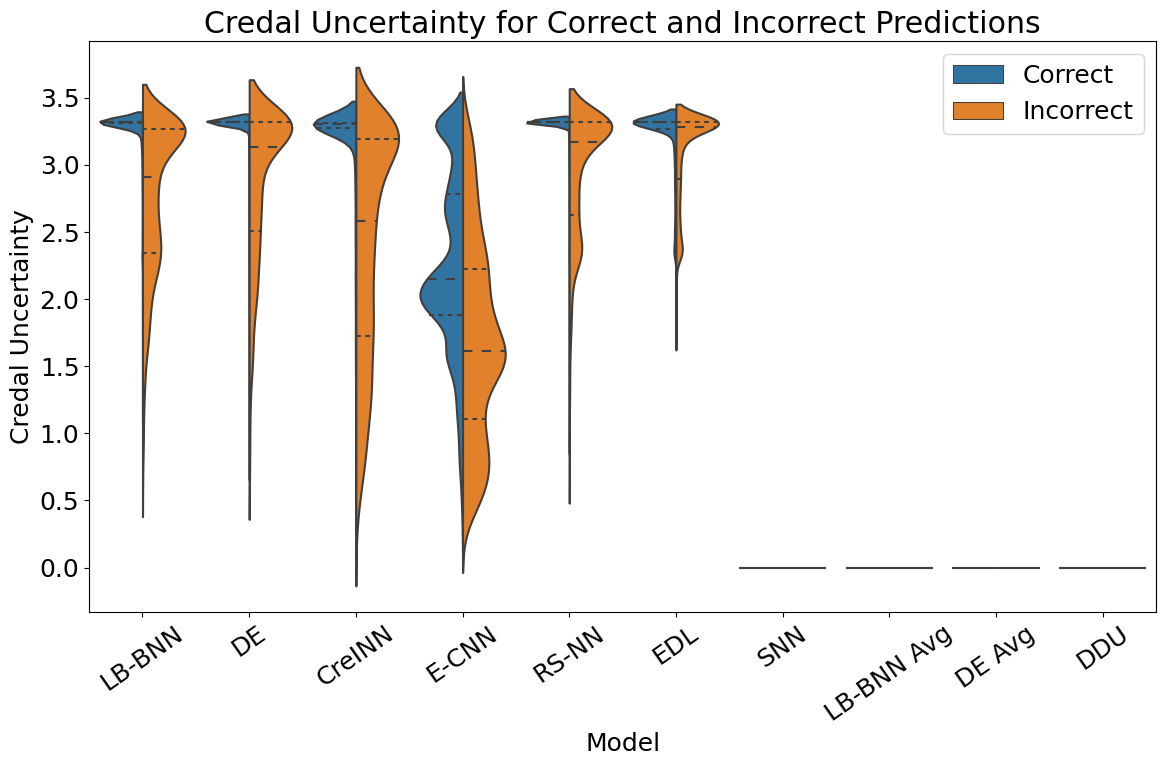

In [150]:
models = {
    "LB-BNN",
    "DE",
    "CreINN",
    "E-CNN",
    "RS-NN",
    "EDL"
}

point_preds = {
    "SNN",
    "LB-BNN Avg",
    "DE Avg",
    "DDU"
}

plt.rcParams.update({'font.size': 18})

def collect_uncertainties(models_dict, unc_models, unc_models_point_preds, indices, indices_avg):
    unc = []
    model_names = []
    
    for model_name in models_dict:
        unc.extend(unc_models[model_name][indices[model_name]])
        model_names.extend([model_name] * len(unc_models[model_name][indices[model_name]]))

    for model_name in point_preds:
        unc.extend(unc_models_point_preds[model_name][indices_avg[model_name]])
        model_names.extend([model_name] * len(unc_models_point_preds[model_name][indices_avg[model_name]]))
    
    return unc, model_names

def prepare_uncertainty_data(models, point_preds, credal_unc_models, credal_unc_models_point_preds, 
                             correct_indices, incorrect_indices, correct_indices_avg, incorrect_indices_avg):
    # Collect Credal uncertainties
    correct_unc, model_names_correct = collect_uncertainties(models, credal_unc_models, credal_unc_models_point_preds, correct_indices, correct_indices_avg)
    incorrect_unc, model_names_incorrect = collect_uncertainties(models, credal_unc_models, credal_unc_models_point_preds, incorrect_indices, incorrect_indices_avg)

    # Create DataFrames for Credal Uncertainty
    df_unc = pd.DataFrame({
        'Model': model_names_correct + model_names_incorrect,
        'Credal Uncertainty': correct_unc + incorrect_unc,
        'Type': ['Correct'] * len(correct_unc) + ['Incorrect'] * len(incorrect_unc)
    }).dropna()

    return df_unc

def plot_violin(ax, df, metric_name):
    df_correct = df[df['Type'] == 'Correct'].copy()
    df_correct['Hue'] = ['Correct'] * len(df_correct)
    sns.violinplot(x='Model', y=metric_name, hue='Type', data=df.set_index("Model").loc[["LB-BNN", "DE", "CreINN", "E-CNN", "RS-NN", "EDL", "SNN", "LB-BNN Avg", "DE Avg", "DDU"]].reset_index(drop=False), split=True, dropna=True, gap=.1, inner="quart", hue_order=['Correct', False], density_norm="width", ax=ax)
    df_incorrect = df[df['Type'] == 'Incorrect'].copy()
    df_incorrect['Hue'] = ['Incorrect'] * len(df_incorrect)
    sns.violinplot(x='Model', y=metric_name, hue='Type', data=df.set_index("Model").loc[["LB-BNN", "DE", "CreINN", "E-CNN", "RS-NN", "EDL", "SNN", "LB-BNN Avg", "DE Avg", "DDU"]].reset_index(drop=False), split=True, dropna=True, gap=.1, inner="quart", hue_order=[False, 'Incorrect'], density_norm="width", ax=ax)

def plot_uncertainty_metrics(models, point_preds, credal_unc_models, credal_unc_models_point_preds, 
                             correct_indices, incorrect_indices, correct_indices_avg, incorrect_indices_avg):
    df_unc = prepare_uncertainty_data(models, point_preds, credal_unc_models, credal_unc_models_point_preds, 
                                       correct_indices, incorrect_indices, correct_indices_avg, incorrect_indices_avg)
    
    # Create and plot Credal Uncertainty
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_violin(ax, df_unc, 'Credal Uncertainty')
    plt.title('Credal Uncertainty for Correct and Incorrect Predictions')
    plt.ylabel('Credal Uncertainty')
    ax.legend(ax.legend_.__dict__["legend_handles"][:2], ['Correct', 'Incorrect'])
    plt.xticks(rotation=0)
    
    # Set axis labels and other details
    plt.xticks(rotation=35)
    plt.tight_layout()
    plt.show()
    
    return df_unc

# Assuming you have credal_unc_models, and indices defined appropriately
df_unc = plot_uncertainty_metrics(models, point_preds, uncertainty_df, uncertainty_df_point, 
                                   correct_indices, incorrect_indices, correct_indices_avg, incorrect_indices_avg)


<Figure size 1200x800 with 0 Axes>

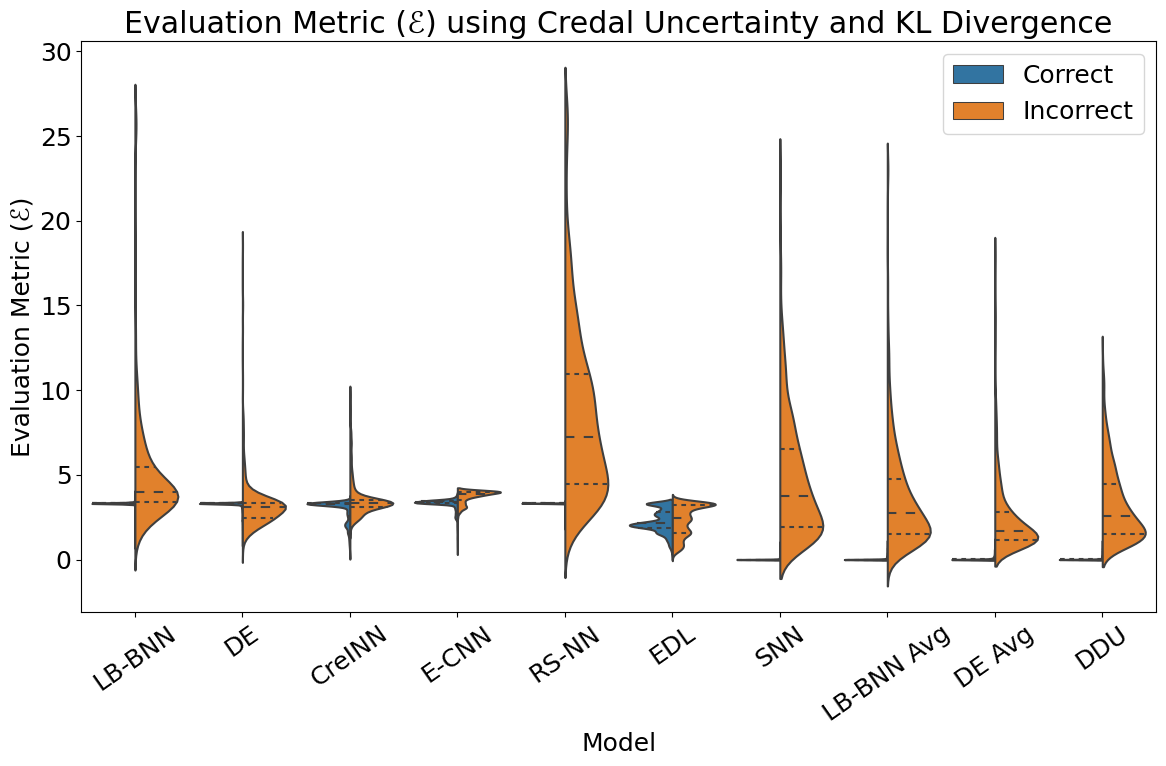

<Figure size 1200x800 with 0 Axes>

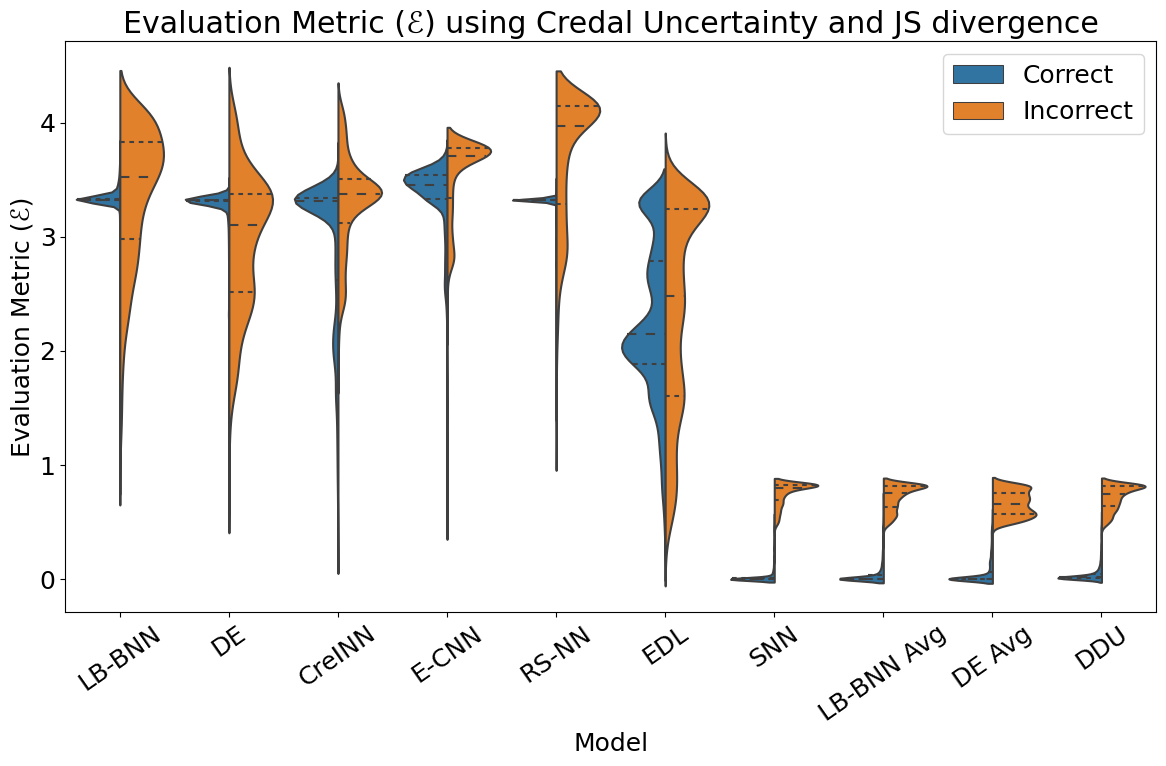

In [151]:
# Plot KL+NS
df_kl["combined_alt_ns_kl"] = df_kl["KL Divergence"] + df_unc["Credal Uncertainty"] #\lambda = 1
df_js["combined_alt_ns_js"] = df_js["JS Divergence"] + df_unc["Credal Uncertainty"] #\lambda = 1

# Plot the violin plot
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(12, 8))
plot_violin(ax, df_kl, 'combined_alt_ns_kl')
plt.title('Evaluation Metric (\u2130) using Credal Uncertainty and KL Divergence')
ax.legend(ax.legend_.__dict__["legend_handles"][:2] ,['Correct', 'Incorrect'])
plt.ylabel('Evaluation Metric (\u2130)')
plt.xticks(rotation=35)
plt.tight_layout()
plt.show()

# Plot the violin plot
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(12, 8))
plot_violin(ax, df_js, 'combined_alt_ns_js')
plt.title('Evaluation Metric (\u2130) using Credal Uncertainty and JS divergence')
ax.legend(ax.legend_.__dict__["legend_handles"][:2] ,['Correct', 'Incorrect'])
plt.ylabel('Evaluation Metric (\u2130)')
plt.xticks(rotation=35)
plt.tight_layout()
plt.show()

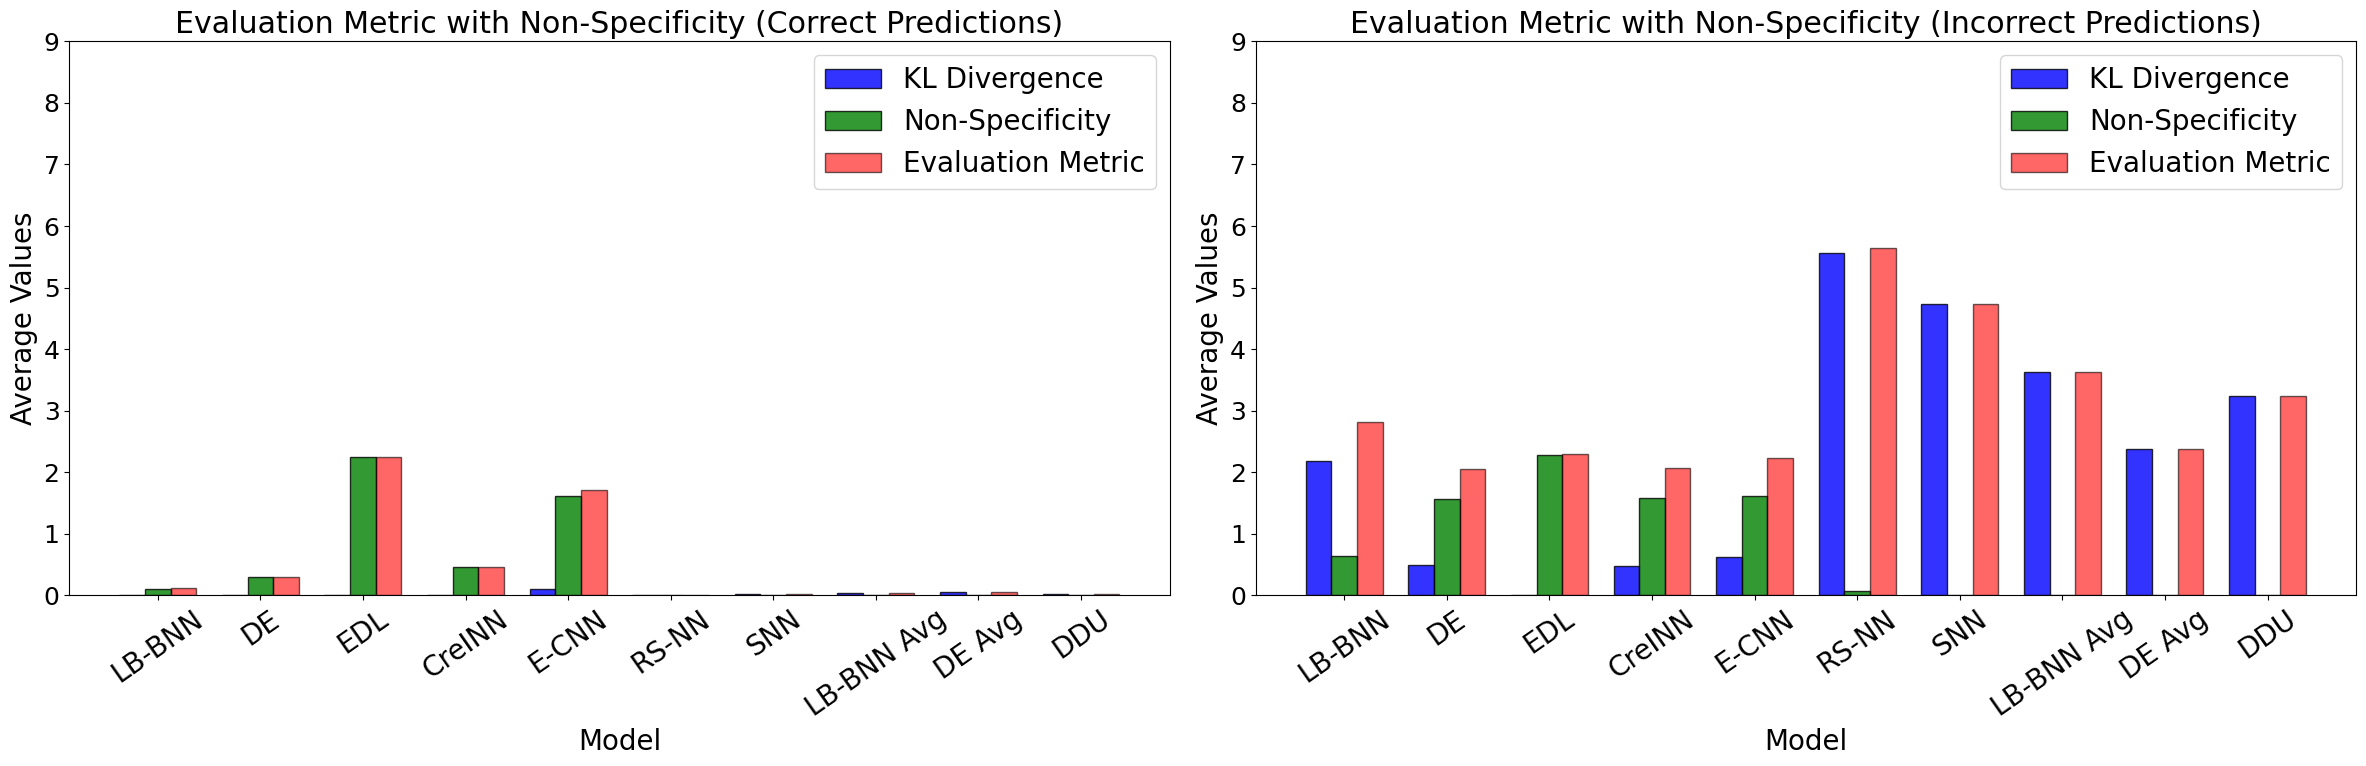

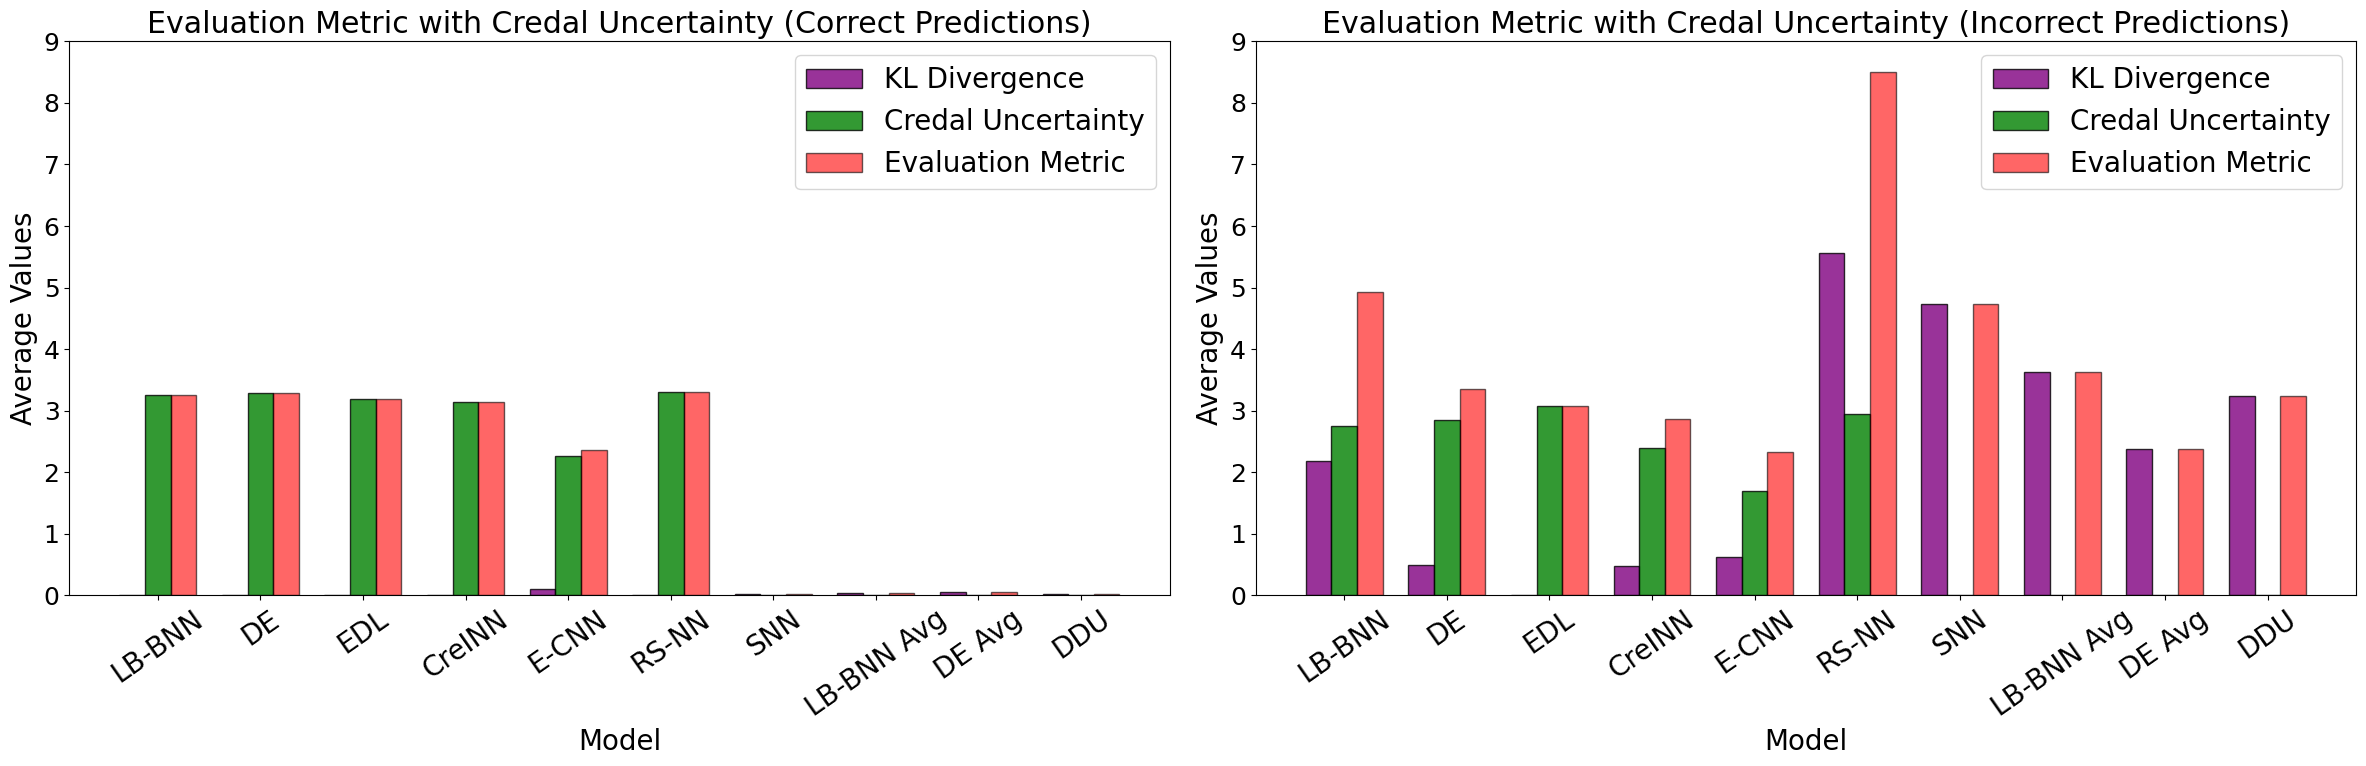

In [152]:
desired_order = ["LB-BNN", "DE", "EDL", "CreINN", "E-CNN", "RS-NN", "SNN", "LB-BNN Avg", "DE Avg", "DDU"]
plt.rcParams.update({'font.size': 18})

# Function to create bar plots
def create_bar_plots(axes, df_kl, df_ns, title, type_pred):
    bar_width = 0.25
    x = np.arange(len(desired_order))

    df_means = df_kl[df_kl['Type'] == type_pred].groupby('Model').mean(numeric_only=True)
    df_spec_means = df_ns[df_ns['Type'] == type_pred].groupby('Model').mean(numeric_only=True)

    # Calculate combined metric
    df_means['combined'] = df_means['KL Divergence'] + df_spec_means['Non-Specificity']

    # Bar plots for KL Divergence, Non-Specificity, and Combined Metric
    axes.bar(x - bar_width, df_means['KL Divergence'].loc[desired_order], 
             width=bar_width, color='blue', alpha=0.8, edgecolor='black', label='KL Divergence')
    axes.bar(x, df_spec_means['Non-Specificity'].loc[desired_order], 
             width=bar_width, color='green', alpha=0.8, edgecolor='black', label='Non-Specificity')
    axes.bar(x + bar_width, df_means['combined'].loc[desired_order], 
             width=bar_width, color='red', alpha=0.6, edgecolor='black', label='Evaluation Metric')

    axes.set_title(title)
    axes.set_xlabel('Model', fontsize=20)
    axes.set_ylabel('Average Values', fontsize=20)
    axes.set_xticks(x)
    axes.set_xticklabels(desired_order, rotation=35, fontsize=20)
    axes.legend(fontsize=20)
    
    axes.set_ylim(0, 9)

fig, axes = plt.subplots(1, 2, figsize=(24, 8))
create_bar_plots(axes[0], df_kl, df_spec, 'Evaluation Metric with Non-Specificity (Correct Predictions)', 'Correct')
create_bar_plots(axes[1], df_kl, df_spec, 'Evaluation Metric with Non-Specificity (Incorrect Predictions)', 'Incorrect')

plt.tight_layout()
plt.show()

# JS Divergence plots
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

def create_js_bar_plots(axes, df_js, df_ns2, title, type_pred):
    bar_width = 0.25
    x = np.arange(len(desired_order))

    df_js_means = df_js[df_js['Type'] == type_pred].groupby('Model').mean(numeric_only=True)
    df_spec_means_2 = df_ns2[df_ns2['Type'] == type_pred].groupby('Model').mean(numeric_only=True)

    # Calculate evaluation metric
    df_js_means['combined_alt_ns_kl'] = df_js_means['KL Divergence'] + df_spec_means_2['Credal Uncertainty']

    # Bar plots for JS Divergence, Non-Specificity, and Evaluation Metric
    axes.bar(x - bar_width, df_js_means['KL Divergence'].loc[desired_order], 
             width=bar_width, color='purple', alpha=0.8, edgecolor='black', label='KL Divergence')
    axes.bar(x, df_spec_means_2['Credal Uncertainty'].loc[desired_order], 
             width=bar_width, color='green', alpha=0.8, edgecolor='black', label='Credal Uncertainty')
    axes.bar(x + bar_width, df_js_means['combined_alt_ns_kl'].loc[desired_order], 
             width=bar_width, color='red', alpha=0.6, edgecolor='black', label='Evaluation Metric')

    axes.set_title(title)
    axes.set_xlabel('Model', fontsize=20)
    axes.set_ylabel('Average Values', fontsize=20)
    axes.set_xticks(x)
    axes.set_xticklabels(desired_order, rotation=35, fontsize=20)
    axes.legend(fontsize=20)

    axes.set_ylim(0, 9)

create_js_bar_plots(axes[0], df_kl, df_unc, 'Evaluation Metric with Credal Uncertainty (Correct Predictions)', 'Correct')
create_js_bar_plots(axes[1], df_kl, df_unc, 'Evaluation Metric with Credal Uncertainty (Incorrect Predictions)', 'Incorrect')

plt.tight_layout()
plt.show()

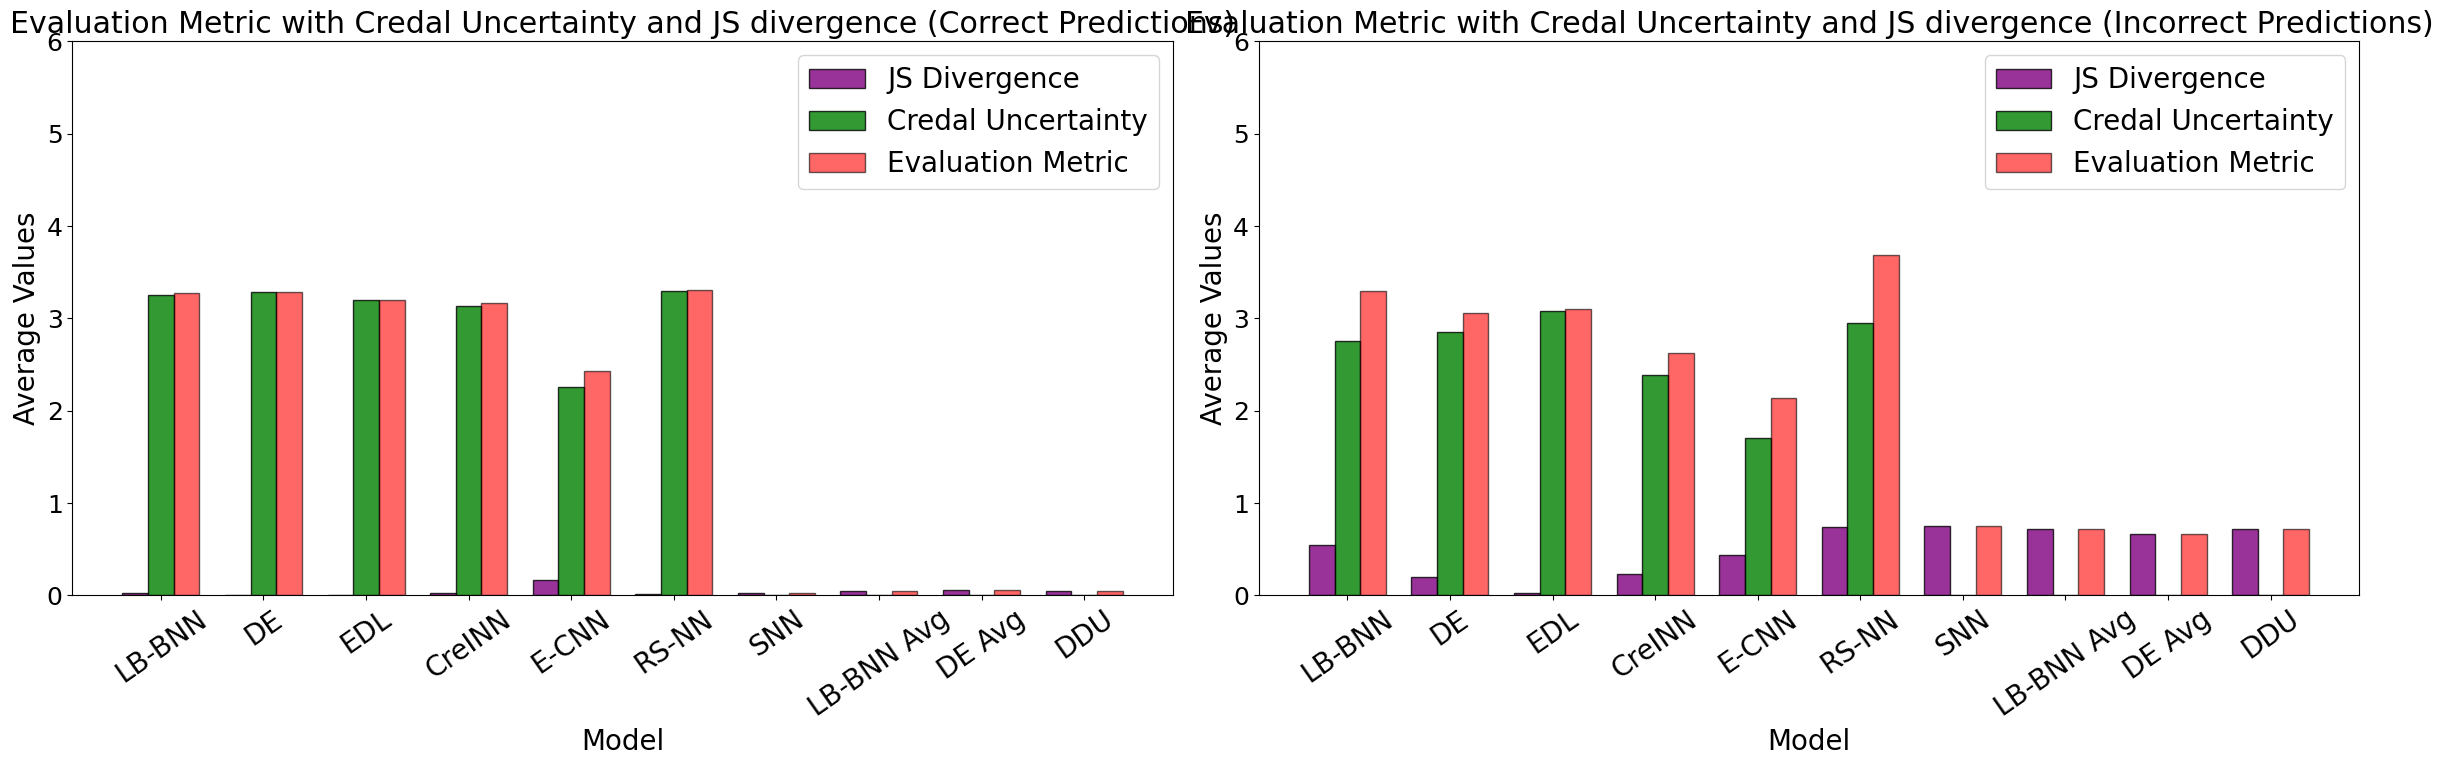

In [153]:
# JS Divergence plots
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

def create_js_bar_plots(axes, df_js, df_ns2, title, type_pred):
    bar_width = 0.25
    x = np.arange(len(desired_order))

    df_js_means = df_js[df_js['Type'] == type_pred].groupby('Model').mean(numeric_only=True)
    df_spec_means_2 = df_ns2[df_ns2['Type'] == type_pred].groupby('Model').mean(numeric_only=True)

    # Calculate evaluation metric
    df_js_means['combined_alt_ns_js'] = df_js_means['JS Divergence'] + df_spec_means_2['Credal Uncertainty']

    # Bar plots for JS Divergence, Non-Specificity, and Evaluation Metric
    axes.bar(x - bar_width, df_js_means['JS Divergence'].loc[desired_order], 
             width=bar_width, color='purple', alpha=0.8, edgecolor='black', label='JS Divergence')
    axes.bar(x, df_spec_means_2['Credal Uncertainty'].loc[desired_order], 
             width=bar_width, color='green', alpha=0.8, edgecolor='black', label='Credal Uncertainty')
    axes.bar(x + bar_width, df_js_means['combined_alt_ns_js'].loc[desired_order], 
             width=bar_width, color='red', alpha=0.6, edgecolor='black', label='Evaluation Metric')


    axes.set_title(title)
    axes.set_xlabel('Model', fontsize=20)
    axes.set_ylabel('Average Values', fontsize=20)
    axes.set_xticks(x)
    axes.set_xticklabels(desired_order, rotation=35, fontsize=20)
    axes.legend(fontsize=20)

    axes.set_ylim(0, 6)

create_js_bar_plots(axes[0], df_js, df_unc, 'Evaluation Metric with Credal Uncertainty and JS divergence (Correct Predictions)', 'Correct')
create_js_bar_plots(axes[1], df_js, df_unc, 'Evaluation Metric with Credal Uncertainty and JS divergence (Incorrect Predictions)', 'Incorrect')

plt.tight_layout()
plt.show()

In [154]:
uncertainty_df

,LB-BNN,DE,EDL,CreINN,E-CNN,RS-NN
0,3.321669,3.321928,3.271908,3.311469,2.016901,3.321928
1,3.321928,3.321928,3.321928,3.301988,2.182972,3.321928
2,3.308177,3.321906,3.321928,3.316237,2.116824,2.980876
3,3.315624,3.321926,3.321928,3.299429,1.803406,3.321137
4,3.321884,3.321928,3.321928,3.307156,2.777519,3.321928
...,...,...,...,...,...,...
9995,3.242713,3.321871,3.307971,3.239206,0.540740,3.321928
9996,3.235957,3.321904,2.404617,2.987351,1.436856,2.371024
9997,3.321832,3.321928,3.306482,3.289673,1.967786,3.321928
9998,3.321928,3.321928,3.279209,3.311591,1.502270,3.321928


In [155]:
# Print the structure to verify
print(uncertainty_df.columns)
print(uncertainty_df.head())

# Convert the uncertainty DataFrame to a dictionary
uncertainty_dict = {
    model_name: uncertainty_df[model_name].to_numpy()  # Convert each column to a numpy array
    for model_name in uncertainty_df.columns
}

print("Uncertainty Dictionary:")
print(uncertainty_dict)

uncertainty_point_dict = {
    model_name: uncertainty_df_point[model_name].to_numpy()  # Convert each column to a numpy array
    for model_name in uncertainty_df_point.columns
}

print("\nUpdated Uncertainty Point Dictionary:")
print(uncertainty_point_dict)

Index(['LB-BNN', 'DE', 'EDL', 'CreINN', 'E-CNN', 'RS-NN'], dtype='object')
     LB-BNN        DE       EDL    CreINN     E-CNN     RS-NN
0  3.321669  3.321928  3.271908  3.311469  2.016901  3.321928
1  3.321928  3.321928  3.321928  3.301988  2.182972  3.321928
2  3.308177  3.321906  3.321928  3.316237  2.116824  2.980876
3  3.315624  3.321926  3.321928  3.299429  1.803406  3.321137
4  3.321884  3.321928  3.321928  3.307156  2.777519  3.321928
Uncertainty Dictionary:
{'LB-BNN': array([3.32166881, 3.32192805, 3.30817673, ..., 3.32183192, 3.32192779,
       3.3219222 ]), 'DE': array([3.32192806, 3.32192806, 3.32190572, ..., 3.32192806, 3.32192806,
       3.32192806]), 'EDL': array([3.27190779, 3.32192806, 3.32192806, ..., 3.30648191, 3.27920923,
       3.32192806]), 'CreINN': array([3.31146852, 3.30198797, 3.31623697, ..., 3.28967286, 3.31159108,
       3.30086173]), 'E-CNN': array([2.01690105, 2.18297165, 2.11682447, ..., 1.96778649, 1.50226986,
       3.30164048]), 'RS-NN': array([3.321

In [156]:
kl_divs_models.update(kl_divs_models_point_preds)
uncertainty_dict.update(uncertainty_point_dict)
eval_metrics_credal_unc_kl = calculate_eval_metric(kl_divs_models, uncertainty_dict, lambda_values)

In [157]:
print("Model Selection based on Evaluation Metric (using JS divergence)\n")

for lambda_val in lambda_values:
    rankings = []
    for model_name in eval_metrics_credal_unc_kl:
        if lambda_val in eval_metrics_credal_unc_kl[model_name]:
            metric_value = eval_metrics_credal_unc_kl[model_name][lambda_val]          
            if isinstance(metric_value, (np.ndarray, list)) and len(metric_value) > 0:
                average_metric_value = np.mean(metric_value)
                rankings.append((model_name, average_metric_value))

    rankings.sort(key=lambda x: x[1])
    
    model_names = [model_name for model_name, _ in rankings]
    metrics = [metric for _, metric in rankings]
    
    print(f"Lambda {lambda_val} -> {', '.join(model_names)}")
    print(f"[{', '.join(f'{metric:.3f}' for metric in metrics)}]")

Model Selection based on Evaluation Metric (using JS divergence)

Lambda 0 -> EDL, DE, CreINN, E-CNN, DE Avg, LB-BNN, DDU, RS-NN, LB-BNN Avg, SNN
[0.002, 0.031, 0.058, 0.193, 0.195, 0.243, 0.309, 0.398, 0.420, 0.481]
Lambda 0.1 -> DE Avg, DDU, EDL, DE, CreINN, E-CNN, LB-BNN Avg, SNN, LB-BNN, RS-NN
[0.195, 0.309, 0.317, 0.357, 0.363, 0.410, 0.420, 0.481, 0.563, 0.726]
Lambda 0.2 -> DE Avg, DDU, LB-BNN Avg, SNN, E-CNN, EDL, CreINN, DE, LB-BNN, RS-NN
[0.195, 0.309, 0.420, 0.481, 0.627, 0.631, 0.668, 0.683, 0.883, 1.053]
Lambda 0.3 -> DE Avg, DDU, LB-BNN Avg, SNN, E-CNN, EDL, CreINN, DE, LB-BNN, RS-NN
[0.195, 0.309, 0.420, 0.481, 0.844, 0.946, 0.973, 1.009, 1.202, 1.380]
Lambda 0.4 -> DE Avg, DDU, LB-BNN Avg, SNN, E-CNN, EDL, CreINN, DE, LB-BNN, RS-NN
[0.195, 0.309, 0.420, 0.481, 1.061, 1.261, 1.279, 1.335, 1.522, 1.707]
Lambda 0.5 -> DE Avg, DDU, LB-BNN Avg, SNN, E-CNN, EDL, CreINN, DE, LB-BNN, RS-NN
[0.195, 0.309, 0.420, 0.481, 1.277, 1.575, 1.584, 1.661, 1.842, 2.034]
Lambda 0.6 -> DE A